In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Step 1: Load and Prepare Initial Data (No changes here) ---
print("Loading and preparing data...")
df = pd.read_csv("allcleaned_dataset.csv", parse_dates=['BillingDate'])
required_cols = ['BillingDate', 'Grade', 'NetValueItemTHB', 'Quantity']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"CSV must contain the following columns: {required_cols}")
df = df.set_index('BillingDate')
unique_grades = df['Grade'].unique()
print(f"Found {len(unique_grades)} unique grades to forecast: {unique_grades}")

Loading and preparing data...
Found 341 unique grades to forecast: ['D777C' '10901WHA' '10901CLA' 'P722JO' 'SF580' 'SP660' 'HA001A' 'S199F'
 'P601F' 'H5480S' 'P400S' 'P401S' 'H5840B' 'P700J' 'P440J' 'P403J'
 'L1810FI' 'L2009FA' 'L2009F' 'H6140B' 'P851JO' 'SG710' 'H5604F' 'P838C'
 'SG610' 'SG660' 'SG760' 'HA002A' 'SG580' 'SG66J' 'P701J3' 'X861T' 'P840J'
 'P740J3' 'P639AT' 'P765J' 'P901J' 'P740J' 'P640J3' 'P739ET' 'P842J'
 'P841J' 'M3804RU' 'P640J' 'P441JU' 'P702J' 'P744J' 'H455JA' 'H655JA'
 'P642J' 'P607F' 'WD2040P' 'H555JA' 'P303S' 'H512W' 'H800B' 'D477C'
 '17801WHA' 'P701J' 'H6430BM' 'F15' 'P686J' 'P750J' 'H6670B' 'P602F'
 'SB32L' 'SG71R' 'SC71J' 'SC840' 'H1000PBL' 'H1000PC' 'H355JA' 'P705JM'
 'PG680' 'PG740' 'P350F' 'P483JU' 'SG71Z' 'SG71J' 'SM760' 'P902J' 'H619F'
 'WD2110P' 'P780J' 'WD2300U' 'PF741' 'PG770' 'H567J' 'P655IM' 'H112PC'
 'LP1040T' 'SB31L' 'SW201' 'SW202' 'SW401' 'PA17L' 'P747WT' 'LP1300L'
 'PC750' 'P443J' 'H377C' 'SM660' 'SC760' 'WD2040PX' 'LP0100F' 'P348S'
 'LP0020P' '

In [30]:
import pandas as pd
import numpy as np

# --- Step 1 & 2 (Setup and Initial Check - No changes) ---
print("--- Step 1 & 2: Loading and Initial Checks ---")
# (Using the same dummy data generation as before to demonstrate the fix)
try:
    df = pd.read_csv("allcleaned_dataset.csv", parse_dates=['BillingDate'])
except FileNotFoundError:
    print("Dummy data created as 'allcleaned_dataset.csv' was not found.")
    dates = pd.to_datetime(pd.date_range(start='2021-01-15', end='2023-11-20', freq='D'))
    data = {'BillingDate': dates, 'Grade': np.random.choice(['A', 'B', 'C'], size=len(dates)), 
    'NetValueItemTHB': np.random.uniform(100, 5000, size=len(dates)), 'Quantity': np.random.randint(1, 10, size=len(dates))}
    df = pd.DataFrame(data)
    condition_to_remove = (df['Grade'] == 'B') & (pd.to_datetime(df['BillingDate']).dt.year == 2022) & (pd.to_datetime(df['BillingDate']).dt.month == 3)
    df = df[~condition_to_remove]
    condition_to_remove_2 = (df['Grade'] == 'A') & (pd.to_datetime(df['BillingDate']).dt.year == 2023) & (pd.to_datetime(df['BillingDate']).dt.month.isin([4, 5]))
    df = df[~condition_to_remove_2]
    df.to_csv("allcleaned_dataset.csv", index=False)

required_cols = ['BillingDate', 'Grade', 'NetValueItemTHB', 'Quantity']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"CSV must contain the following columns: {required_cols}")

df['BillingDate'] = pd.to_datetime(df['BillingDate'])
df = df.set_index('BillingDate')
unique_grades = df['Grade'].unique()
print("-" * 20)

# --- Step 3: Verify Data Completeness PER GRADE (Shows the problem) ---
print("\n--- Step 3: Verifying completeness of ORIGINAL data... ---")
months_per_grade_year = df.groupby([df['Grade'], df.index.year]).apply(lambda group: group.index.month.nunique())
incomplete_grade_years = months_per_grade_year[months_per_grade_year < 12]
if incomplete_grade_years.empty:
    print("Original data is already complete.")
else:
    print("⚠️ Warning: Original data has missing months for some grades.")
    for (grade, year), count in incomplete_grade_years.items():
        print(f"  - Grade '{grade}' in Year {year} has {count}/12 months.")
print("-" * 20)


# Fill Missing Monthly Data
print("\n--- Step 4: Aggregating data and filling missing months with zero... ---")

# Part 1: Aggregate the existing daily data into monthly sums for each grade.
# This part remains the same.
print("Aggregating daily data to monthly sums...")
monthly_data = df.groupby('Grade').resample('MS').agg({
    'Quantity': 'sum', 
    'NetValueItemTHB': 'sum'
})

# Part 2: Create the complete "scaffold" index.
# This is the corrected logic.
print("Creating a complete scaffold index covering FULL years...")

# <<< CHANGE: Find the first day of the earliest year in the data.
start_date = pd.Timestamp(f'{df.index.year.min()}-01-01')

# <<< CHANGE: Find the last day of the latest year in the data.
end_date = pd.Timestamp(f'{df.index.year.max()}-12-31')

print(f"Scaffold will span from {start_date.date()} to {end_date.date()}")

all_months = pd.date_range(start=start_date, end=end_date, freq='MS')
scaffold_index = pd.MultiIndex.from_product(
    [unique_grades, all_months],
    names=['Grade', 'BillingDate']
)

# Part 3: Reindex the aggregated data to the complete scaffold.
print("Reindexing data to the scaffold to find gaps...")
complete_df = monthly_data.reindex(scaffold_index)

# Part 4: Fill the NaN values with 0.
print("Filling gaps with zero...")
complete_df = complete_df.fillna(0)

# Part 5: Convert Quantity back to an integer type for cleanliness.
complete_df['Quantity'] = complete_df['Quantity'].astype(int)

# Reset the index to turn 'Grade' and 'BillingDate' back into columns.
complete_df = complete_df.reset_index()

print("✅ Success: A new DataFrame 'complete_df' has been created with no gaps.")
print("Original DataFrame rows:", len(df))
print("New Complete Monthly DataFrame rows:", len(complete_df))
print("\nPreview of the new complete DataFrame:")
print(complete_df.head())
print("-" * 20)


# --- Step 5: Re-verify Completeness on the NEW DataFrame ---
print("\n--- Step 5: Verifying completeness of the NEW 'complete_df'... ---")

# We need to set the date as index again for the check to work
check_df = complete_df.set_index('BillingDate')
final_check = check_df.groupby(['Grade', check_df.index.year]).apply(lambda g: g.index.month.nunique())
final_incomplete = final_check[final_check < 12]

if final_incomplete.empty:
    print("✅ Success! The new 'complete_df' has data for all 12 months for every grade in every full year.")
else:
    print("⚠️ Error: The filling process failed. There are still gaps.")
    print(final_incomplete)

print("-" * 20)

--- Step 1 & 2: Loading and Initial Checks ---
--------------------

--- Step 3: Verifying completeness of ORIGINAL data... ---


C:\Users\2025trainees99\AppData\Local\Temp\ipykernel_2156\2543516306.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  months_per_grade_year = df.groupby([df['Grade'], df.index.year]).apply(lambda group: group.index.month.nunique())


⚠️ Warning: Original data has missing months for some grades.
  - Grade '10901CLA' in Year 2022 has 9/12 months.
  - Grade '10901WHA' in Year 2023 has 11/12 months.
  - Grade '10902CLA' in Year 2022 has 1/12 months.
  - Grade '10908WHA' in Year 2022 has 10/12 months.
  - Grade '10908WHA' in Year 2023 has 2/12 months.
  - Grade '10908WHA' in Year 2024 has 2/12 months.
  - Grade '1506BKAP' in Year 2022 has 1/12 months.
  - Grade '1507BKAP' in Year 2024 has 1/12 months.
  - Grade '17801WHA' in Year 2022 has 8/12 months.
  - Grade '17801WHA' in Year 2023 has 3/12 months.
  - Grade '17801WHA' in Year 2024 has 6/12 months.
  - Grade '17804WHE' in Year 2022 has 10/12 months.
  - Grade '3983MBBP' in Year 2024 has 1/12 months.
  - Grade '3985BEA' in Year 2024 has 1/12 months.
  - Grade '3985BKAP' in Year 2022 has 1/12 months.
  - Grade '3985DBA' in Year 2024 has 1/12 months.
  - Grade '60701WHA' in Year 2022 has 2/12 months.
  - Grade '60701WHA' in Year 2023 has 4/12 months.
  - Grade '60701WHA

C:\Users\2025trainees99\AppData\Local\Temp\ipykernel_2156\2543516306.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_check = check_df.groupby(['Grade', check_df.index.year]).apply(lambda g: g.index.month.nunique())


In [31]:
!pip install prophet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [33]:
print("--- Steps 1-5: Loading and Preparing Data ---")
try:
    df = pd.read_csv("allcleaned_dataset.csv", parse_dates=['BillingDate'])
except FileNotFoundError:
    print("Dummy data created as 'allcleaned_dataset.csv' was not found.")
    dates = pd.to_datetime(pd.date_range(start='2021-01-15', end='2023-11-20', freq='D'))
    data = {'BillingDate': dates, 'Grade': np.random.choice(['A', 'B', 'C'], size=len(dates)), 'NetValueItemTHB': np.random.uniform(100, 5000, size=len(dates)), 'Quantity': np.random.randint(1, 10, size=len(dates))}
    df = pd.DataFrame(data)
    condition_to_remove = (df['Grade'] == 'B') & (pd.to_datetime(df['BillingDate']).dt.year == 2022) & (pd.to_datetime(df['BillingDate']).dt.month == 3)
    df = df[~condition_to_remove]
    condition_to_remove_2 = (df['Grade'] == 'A') & (pd.to_datetime(df['BillingDate']).dt.year == 2023) & (pd.to_datetime(df['BillingDate']).dt.month.isin([4, 5]))
    df = df[~condition_to_remove_2]
    df.to_csv("allcleaned_dataset.csv", index=False)
required_cols = ['BillingDate', 'Grade', 'NetValueItemTHB', 'Quantity']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"CSV must contain the following columns: {required_cols}")
df['BillingDate'] = pd.to_datetime(df['BillingDate'])
df = df.set_index('BillingDate')
unique_grades = df['Grade'].unique()

print("\nAggregating data and filling missing months with zero...")
monthly_data = df.groupby('Grade').resample('MS').agg({
    'Quantity': 'sum',
    'NetValueItemTHB': 'sum'
})
start_date = pd.Timestamp(f'{df.index.year.min()}-01-01')
end_date = pd.Timestamp(f'{df.index.year.max()}-12-31')
all_months = pd.date_range(start=start_date, end=end_date, freq='MS')
scaffold_index = pd.MultiIndex.from_product(
    [unique_grades, all_months],
    names=['Grade', 'BillingDate']
)
complete_df = monthly_data.reindex(scaffold_index).fillna(0).astype({'Quantity': int}).reset_index()
print("✅ Success: A new DataFrame 'complete_df' has been created with no gaps.")
print("-" * 50)


--- Steps 1-5: Loading and Preparing Data ---

Aggregating data and filling missing months with zero...
✅ Success: A new DataFrame 'complete_df' has been created with no gaps.
--------------------------------------------------


In [34]:
print("\n--- Step 6: Training a Prophet Model for Each Grade ---")

# We will store our models and forecasts in dictionaries
models = {}
forecasts = {}
unique_grades = complete_df['Grade'].unique()

for grade in unique_grades:
    print(f"\nProcessing Grade: {grade}...")

    # --- Part 1: Prepare data for Prophet ---
    # Prophet requires the columns to be named 'ds' (datestamp) and 'y' (value).
    # We select the data for the current grade and rename the columns.
    prophet_df = complete_df[complete_df['Grade'] == grade][['BillingDate', 'Quantity']].rename(
        columns={'BillingDate': 'ds', 'Quantity': 'y'}
    )
    
    # --- Part 2: Initialize and Fit the Model ---
    # We create a new Prophet model for each grade.
    # yearly_seasonality is automatically detected, which is great for our yearly data.
    model = Prophet()
    model.fit(prophet_df)
    
    # Store the trained model
    models[grade] = model
    
    # --- Part 3: Create Future DataFrame and Predict ---
    # We ask Prophet to create a dataframe for future dates.
    # Here, we forecast for the next 12 months ('MS' = Month Start frequency).
    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)
    
    # Store the forecast results
    forecasts[grade] = forecast
    print(f"✅ Forecasting complete for Grade '{grade}'.")

print("-" * 50)


--- Step 6: Training a Prophet Model for Each Grade ---

Processing Grade: D777C...


10:22:32 - cmdstanpy - INFO - Chain [1] start processing
10:22:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'D777C'.

Processing Grade: 10901WHA...


10:22:33 - cmdstanpy - INFO - Chain [1] start processing
10:22:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '10901WHA'.

Processing Grade: 10901CLA...


10:22:34 - cmdstanpy - INFO - Chain [1] start processing
10:22:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '10901CLA'.

Processing Grade: P722JO...


10:22:35 - cmdstanpy - INFO - Chain [1] start processing
10:22:35 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P722JO'.

Processing Grade: SF580...


10:22:35 - cmdstanpy - INFO - Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SF580'.

Processing Grade: SP660...


10:22:36 - cmdstanpy - INFO - Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SP660'.

Processing Grade: HA001A...


10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'HA001A'.

Processing Grade: S199F...


10:22:37 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S199F'.

Processing Grade: P601F...


10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P601F'.

Processing Grade: H5480S...


10:22:38 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5480S'.

Processing Grade: P400S...


10:22:39 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P400S'.

Processing Grade: P401S...


10:22:40 - cmdstanpy - INFO - Chain [1] start processing
10:22:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P401S'.

Processing Grade: H5840B...


10:22:40 - cmdstanpy - INFO - Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5840B'.

Processing Grade: P700J...


10:22:41 - cmdstanpy - INFO - Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P700J'.

Processing Grade: P440J...


10:22:42 - cmdstanpy - INFO - Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P440J'.

Processing Grade: P403J...


10:22:42 - cmdstanpy - INFO - Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P403J'.

Processing Grade: L1810FI...


10:22:43 - cmdstanpy - INFO - Chain [1] start processing
10:22:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L1810FI'.

Processing Grade: L2009FA...


10:22:43 - cmdstanpy - INFO - Chain [1] start processing
10:22:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L2009FA'.

Processing Grade: L2009F...


10:22:44 - cmdstanpy - INFO - Chain [1] start processing
10:22:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L2009F'.

Processing Grade: H6140B...


10:22:45 - cmdstanpy - INFO - Chain [1] start processing
10:22:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H6140B'.

Processing Grade: P851JO...


10:22:45 - cmdstanpy - INFO - Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P851JO'.

Processing Grade: SG710...


10:22:46 - cmdstanpy - INFO - Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG710'.

Processing Grade: H5604F...


10:22:47 - cmdstanpy - INFO - Chain [1] start processing
10:22:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5604F'.

Processing Grade: P838C...


10:22:47 - cmdstanpy - INFO - Chain [1] start processing
10:22:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P838C'.

Processing Grade: SG610...


10:22:48 - cmdstanpy - INFO - Chain [1] start processing
10:22:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG610'.

Processing Grade: SG660...


10:22:48 - cmdstanpy - INFO - Chain [1] start processing
10:22:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG660'.

Processing Grade: SG760...


10:22:49 - cmdstanpy - INFO - Chain [1] start processing
10:22:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG760'.

Processing Grade: HA002A...


10:22:50 - cmdstanpy - INFO - Chain [1] start processing
10:22:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'HA002A'.

Processing Grade: SG580...


10:22:50 - cmdstanpy - INFO - Chain [1] start processing
10:22:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG580'.

Processing Grade: SG66J...


10:22:51 - cmdstanpy - INFO - Chain [1] start processing
10:22:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG66J'.

Processing Grade: P701J3...


10:22:52 - cmdstanpy - INFO - Chain [1] start processing
10:22:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P701J3'.

Processing Grade: X861T...


10:22:52 - cmdstanpy - INFO - Chain [1] start processing
10:22:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X861T'.

Processing Grade: P840J...


10:22:53 - cmdstanpy - INFO - Chain [1] start processing
10:22:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P840J'.

Processing Grade: P740J3...


10:22:53 - cmdstanpy - INFO - Chain [1] start processing
10:22:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P740J3'.

Processing Grade: P639AT...


10:22:54 - cmdstanpy - INFO - Chain [1] start processing
10:22:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P639AT'.

Processing Grade: P765J...


10:22:55 - cmdstanpy - INFO - Chain [1] start processing
10:22:55 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P765J'.

Processing Grade: P901J...


10:22:55 - cmdstanpy - INFO - Chain [1] start processing
10:22:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P901J'.

Processing Grade: P740J...


10:22:56 - cmdstanpy - INFO - Chain [1] start processing
10:22:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P740J'.

Processing Grade: P640J3...


10:22:57 - cmdstanpy - INFO - Chain [1] start processing
10:22:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P640J3'.

Processing Grade: P739ET...


10:22:57 - cmdstanpy - INFO - Chain [1] start processing
10:22:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P739ET'.

Processing Grade: P842J...


10:22:58 - cmdstanpy - INFO - Chain [1] start processing
10:22:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P842J'.

Processing Grade: P841J...


10:22:59 - cmdstanpy - INFO - Chain [1] start processing
10:22:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P841J'.

Processing Grade: M3804RU...


10:22:59 - cmdstanpy - INFO - Chain [1] start processing
10:22:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M3804RU'.

Processing Grade: P640J...


10:23:00 - cmdstanpy - INFO - Chain [1] start processing
10:23:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P640J'.

Processing Grade: P441JU...


10:23:00 - cmdstanpy - INFO - Chain [1] start processing
10:23:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P441JU'.

Processing Grade: P702J...


10:23:01 - cmdstanpy - INFO - Chain [1] start processing
10:23:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P702J'.

Processing Grade: P744J...


10:23:02 - cmdstanpy - INFO - Chain [1] start processing
10:23:02 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P744J'.

Processing Grade: H455JA...


10:23:02 - cmdstanpy - INFO - Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H455JA'.

Processing Grade: H655JA...


10:23:03 - cmdstanpy - INFO - Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H655JA'.

Processing Grade: P642J...


10:23:04 - cmdstanpy - INFO - Chain [1] start processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P642J'.

Processing Grade: P607F...


10:23:04 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P607F'.

Processing Grade: WD2040P...


10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2040P'.

Processing Grade: H555JA...


10:23:05 - cmdstanpy - INFO - Chain [1] start processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H555JA'.

Processing Grade: P303S...


10:23:06 - cmdstanpy - INFO - Chain [1] start processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P303S'.

Processing Grade: H512W...


10:23:07 - cmdstanpy - INFO - Chain [1] start processing
10:23:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H512W'.

Processing Grade: H800B...


10:23:07 - cmdstanpy - INFO - Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H800B'.

Processing Grade: D477C...


10:23:08 - cmdstanpy - INFO - Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'D477C'.

Processing Grade: 17801WHA...


10:23:09 - cmdstanpy - INFO - Chain [1] start processing
10:23:09 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '17801WHA'.

Processing Grade: P701J...


10:23:09 - cmdstanpy - INFO - Chain [1] start processing
10:23:10 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P701J'.

Processing Grade: H6430BM...


10:23:10 - cmdstanpy - INFO - Chain [1] start processing
10:23:10 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H6430BM'.

Processing Grade: F15...


10:23:10 - cmdstanpy - INFO - Chain [1] start processing
10:23:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'F15'.

Processing Grade: P686J...


10:23:11 - cmdstanpy - INFO - Chain [1] start processing
10:23:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P686J'.

Processing Grade: P750J...


10:23:12 - cmdstanpy - INFO - Chain [1] start processing
10:23:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P750J'.

Processing Grade: H6670B...


10:23:12 - cmdstanpy - INFO - Chain [1] start processing
10:23:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H6670B'.

Processing Grade: P602F...


10:23:13 - cmdstanpy - INFO - Chain [1] start processing
10:23:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P602F'.

Processing Grade: SB32L...


10:23:13 - cmdstanpy - INFO - Chain [1] start processing
10:23:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SB32L'.

Processing Grade: SG71R...


10:23:14 - cmdstanpy - INFO - Chain [1] start processing
10:23:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG71R'.

Processing Grade: SC71J...


10:23:15 - cmdstanpy - INFO - Chain [1] start processing
10:23:15 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SC71J'.

Processing Grade: SC840...


10:23:15 - cmdstanpy - INFO - Chain [1] start processing
10:23:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SC840'.

Processing Grade: H1000PBL...


10:23:16 - cmdstanpy - INFO - Chain [1] start processing
10:23:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000PBL'.

Processing Grade: H1000PC...


10:23:16 - cmdstanpy - INFO - Chain [1] start processing
10:23:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000PC'.

Processing Grade: H355JA...


10:23:17 - cmdstanpy - INFO - Chain [1] start processing
10:23:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H355JA'.

Processing Grade: P705JM...


10:23:18 - cmdstanpy - INFO - Chain [1] start processing
10:23:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P705JM'.

Processing Grade: PG680...


10:23:19 - cmdstanpy - INFO - Chain [1] start processing
10:23:19 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PG680'.

Processing Grade: PG740...


10:23:19 - cmdstanpy - INFO - Chain [1] start processing
10:23:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PG740'.

Processing Grade: P350F...


10:23:20 - cmdstanpy - INFO - Chain [1] start processing
10:23:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P350F'.

Processing Grade: P483JU...


10:23:20 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P483JU'.

Processing Grade: SG71Z...


10:23:21 - cmdstanpy - INFO - Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG71Z'.

Processing Grade: SG71J...


10:23:22 - cmdstanpy - INFO - Chain [1] start processing
10:23:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG71J'.

Processing Grade: SM760...


10:23:22 - cmdstanpy - INFO - Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM760'.

Processing Grade: P902J...


10:23:23 - cmdstanpy - INFO - Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P902J'.

Processing Grade: H619F...


10:23:24 - cmdstanpy - INFO - Chain [1] start processing
10:23:24 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H619F'.

Processing Grade: WD2110P...


10:23:24 - cmdstanpy - INFO - Chain [1] start processing
10:23:24 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2110P'.

Processing Grade: P780J...


10:23:25 - cmdstanpy - INFO - Chain [1] start processing
10:23:25 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P780J'.

Processing Grade: WD2300U...


10:23:25 - cmdstanpy - INFO - Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300U'.

Processing Grade: PF741...


10:23:26 - cmdstanpy - INFO - Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PF741'.

Processing Grade: PG770...


10:23:27 - cmdstanpy - INFO - Chain [1] start processing
10:23:27 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PG770'.

Processing Grade: H567J...


10:23:27 - cmdstanpy - INFO - Chain [1] start processing
10:23:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H567J'.

Processing Grade: P655IM...


10:23:28 - cmdstanpy - INFO - Chain [1] start processing
10:23:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P655IM'.

Processing Grade: H112PC...


10:23:29 - cmdstanpy - INFO - Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H112PC'.

Processing Grade: LP1040T...


10:23:29 - cmdstanpy - INFO - Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1040T'.

Processing Grade: SB31L...


10:23:30 - cmdstanpy - INFO - Chain [1] start processing
10:23:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SB31L'.

Processing Grade: SW201...


10:23:30 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW201'.

Processing Grade: SW202...


10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW202'.

Processing Grade: SW401...


10:23:32 - cmdstanpy - INFO - Chain [1] start processing
10:23:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW401'.

Processing Grade: PA17L...


10:23:32 - cmdstanpy - INFO - Chain [1] start processing
10:23:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PA17L'.

Processing Grade: P747WT...


10:23:33 - cmdstanpy - INFO - Chain [1] start processing
10:23:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P747WT'.

Processing Grade: LP1300L...


10:23:33 - cmdstanpy - INFO - Chain [1] start processing
10:23:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1300L'.

Processing Grade: PC750...


10:23:34 - cmdstanpy - INFO - Chain [1] start processing
10:23:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PC750'.

Processing Grade: P443J...


10:23:35 - cmdstanpy - INFO - Chain [1] start processing
10:23:35 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P443J'.

Processing Grade: H377C...


10:23:35 - cmdstanpy - INFO - Chain [1] start processing
10:23:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H377C'.

Processing Grade: SM660...


10:23:36 - cmdstanpy - INFO - Chain [1] start processing
10:23:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM660'.

Processing Grade: SC760...


10:23:37 - cmdstanpy - INFO - Chain [1] start processing
10:23:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SC760'.

Processing Grade: WD2040PX...


10:23:37 - cmdstanpy - INFO - Chain [1] start processing
10:23:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2040PX'.

Processing Grade: LP0100F...


10:23:38 - cmdstanpy - INFO - Chain [1] start processing
10:23:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0100F'.

Processing Grade: P348S...


10:23:38 - cmdstanpy - INFO - Chain [1] start processing
10:23:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P348S'.

Processing Grade: LP0020P...


10:23:39 - cmdstanpy - INFO - Chain [1] start processing
10:23:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0020P'.

Processing Grade: LP1040P...


10:23:40 - cmdstanpy - INFO - Chain [1] start processing
10:23:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1040P'.

Processing Grade: LP1022P...


10:23:40 - cmdstanpy - INFO - Chain [1] start processing
10:23:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1022P'.

Processing Grade: LP1024P...


10:23:41 - cmdstanpy - INFO - Chain [1] start processing
10:23:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1024P'.

Processing Grade: LP1208P...


10:23:41 - cmdstanpy - INFO - Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1208P'.

Processing Grade: SM71E...


10:23:42 - cmdstanpy - INFO - Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM71E'.

Processing Grade: SG58J...


10:23:43 - cmdstanpy - INFO - Chain [1] start processing
10:23:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG58J'.

Processing Grade: P809JM...


10:23:43 - cmdstanpy - INFO - Chain [1] start processing
10:23:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P809JM'.

Processing Grade: H2001WC...


10:23:44 - cmdstanpy - INFO - Chain [1] start processing
10:23:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H2001WC'.

Processing Grade: P945J...


10:23:44 - cmdstanpy - INFO - Chain [1] start processing
10:23:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P945J'.

Processing Grade: S111F...


10:23:45 - cmdstanpy - INFO - Chain [1] start processing
10:23:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S111F'.

Processing Grade: SMX551BU...


10:23:46 - cmdstanpy - INFO - Chain [1] start processing
10:23:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SMX551BU'.

Processing Grade: WD2020P...


10:23:46 - cmdstanpy - INFO - Chain [1] start processing
10:23:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2020P'.

Processing Grade: LP0040P...


10:23:47 - cmdstanpy - INFO - Chain [1] start processing
10:23:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0040P'.

Processing Grade: M545WC...


10:23:48 - cmdstanpy - INFO - Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M545WC'.

Processing Grade: H5814J...


10:23:48 - cmdstanpy - INFO - Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5814J'.

Processing Grade: SG840...


10:23:49 - cmdstanpy - INFO - Chain [1] start processing
10:23:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG840'.

Processing Grade: SM61S...


10:23:49 - cmdstanpy - INFO - Chain [1] start processing
10:23:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM61S'.

Processing Grade: P405F...


10:23:50 - cmdstanpy - INFO - Chain [1] start processing
10:23:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P405F'.

Processing Grade: X811T...


10:23:51 - cmdstanpy - INFO - Chain [1] start processing
10:23:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X811T'.

Processing Grade: LP1020P...


10:23:51 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1020P'.

Processing Grade: SG730...


10:23:52 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG730'.

Processing Grade: P1085J...


10:23:53 - cmdstanpy - INFO - Chain [1] start processing
10:23:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P1085J'.

Processing Grade: P704JM...


10:23:53 - cmdstanpy - INFO - Chain [1] start processing
10:23:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P704JM'.

Processing Grade: H567JA...


10:23:54 - cmdstanpy - INFO - Chain [1] start processing
10:23:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H567JA'.

Processing Grade: SX002JA...


10:23:55 - cmdstanpy - INFO - Chain [1] start processing
10:23:55 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SX002JA'.

Processing Grade: SW101...


10:23:55 - cmdstanpy - INFO - Chain [1] start processing
10:23:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW101'.

Processing Grade: SW102...


10:23:56 - cmdstanpy - INFO - Chain [1] start processing
10:23:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW102'.

Processing Grade: SM58S...


10:23:57 - cmdstanpy - INFO - Chain [1] start processing
10:23:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM58S'.

Processing Grade: OX306P...


10:23:57 - cmdstanpy - INFO - Chain [1] start processing
10:23:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'OX306P'.

Processing Grade: SX002J...


10:23:58 - cmdstanpy - INFO - Chain [1] start processing
10:23:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SX002J'.

Processing Grade: SF58S...


10:23:59 - cmdstanpy - INFO - Chain [1] start processing
10:23:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SF58S'.

Processing Grade: LP5300L...


10:24:00 - cmdstanpy - INFO - Chain [1] start processing
10:24:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP5300L'.

Processing Grade: LP4300L...


10:24:00 - cmdstanpy - INFO - Chain [1] start processing
10:24:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP4300L'.

Processing Grade: LP7300L...


10:24:01 - cmdstanpy - INFO - Chain [1] start processing
10:24:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP7300L'.

Processing Grade: M3204RU...


10:24:02 - cmdstanpy - INFO - Chain [1] start processing
10:24:02 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M3204RU'.

Processing Grade: P745J...
✅ Forecasting complete for Grade 'P745J'.

Processing Grade: D682PC...


10:24:03 - cmdstanpy - INFO - Chain [1] start processing
10:24:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'D682PC'.

Processing Grade: H5211PC...


10:24:03 - cmdstanpy - INFO - Chain [1] start processing
10:24:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5211PC'.

Processing Grade: D388C...


10:24:04 - cmdstanpy - INFO - Chain [1] start processing
10:24:05 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'D388C'.

Processing Grade: PF621...


10:24:05 - cmdstanpy - INFO - Chain [1] start processing
10:24:05 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PF621'.

Processing Grade: M3804RW...


10:24:06 - cmdstanpy - INFO - Chain [1] start processing
10:24:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M3804RW'.

Processing Grade: LP0200F...


10:24:06 - cmdstanpy - INFO - Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0200F'.

Processing Grade: M735RWP...


10:24:07 - cmdstanpy - INFO - Chain [1] start processing
10:24:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M735RWP'.

Processing Grade: SM66E...


10:24:08 - cmdstanpy - INFO - Chain [1] start processing
10:24:08 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM66E'.

Processing Grade: P845J...


10:24:08 - cmdstanpy - INFO - Chain [1] start processing
10:24:09 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P845J'.

Processing Grade: 17804WHE...


10:24:09 - cmdstanpy - INFO - Chain [1] start processing
10:24:09 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '17804WHE'.

Processing Grade: H6105JU...


10:24:10 - cmdstanpy - INFO - Chain [1] start processing
10:24:10 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H6105JU'.

Processing Grade: BIOC01FN...


10:24:10 - cmdstanpy - INFO - Chain [1] start processing
10:24:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'BIOC01FN'.

Processing Grade: M3804RWP...


10:24:11 - cmdstanpy - INFO - Chain [1] start processing
10:24:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M3804RWP'.

Processing Grade: H555J...


10:24:12 - cmdstanpy - INFO - Chain [1] start processing
10:24:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H555J'.

Processing Grade: M9001RWP...


10:24:12 - cmdstanpy - INFO - Chain [1] start processing
10:24:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M9001RWP'.

Processing Grade: M9001RW...


10:24:13 - cmdstanpy - INFO - Chain [1] start processing
10:24:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M9001RW'.

Processing Grade: 10908WHA...


10:24:14 - cmdstanpy - INFO - Chain [1] start processing
10:24:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '10908WHA'.

Processing Grade: P440J3...


10:24:14 - cmdstanpy - INFO - Chain [1] start processing
10:24:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P440J3'.

Processing Grade: SM71S...


10:24:15 - cmdstanpy - INFO - Chain [1] start processing
10:24:15 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM71S'.

Processing Grade: PF682...


10:24:15 - cmdstanpy - INFO - Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PF682'.

Processing Grade: SM84E...


10:24:16 - cmdstanpy - INFO - Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM84E'.

Processing Grade: LP0400F...


10:24:17 - cmdstanpy - INFO - Chain [1] start processing
10:24:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0400F'.

Processing Grade: GG700...


10:24:17 - cmdstanpy - INFO - Chain [1] start processing
10:24:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'GG700'.

Processing Grade: LP1023P...


10:24:18 - cmdstanpy - INFO - Chain [1] start processing
10:24:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1023P'.

Processing Grade: M90WTT2P...


10:24:19 - cmdstanpy - INFO - Chain [1] start processing
10:24:19 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90WTT2P'.

Processing Grade: LP8110P...


10:24:19 - cmdstanpy - INFO - Chain [1] start processing
10:24:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP8110P'.

Processing Grade: H1000P...


10:24:20 - cmdstanpy - INFO - Chain [1] start processing
10:24:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000P'.

Processing Grade: H1000PWI...


10:24:21 - cmdstanpy - INFO - Chain [1] start processing
10:24:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000PWI'.

Processing Grade: SM840...


10:24:21 - cmdstanpy - INFO - Chain [1] start processing
10:24:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM840'.

Processing Grade: P840J3...


10:24:22 - cmdstanpy - INFO - Chain [1] start processing
10:24:22 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P840J3'.

Processing Grade: M90BKT3R...


10:24:23 - cmdstanpy - INFO - Chain [1] start processing
10:24:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90BKT3R'.

Processing Grade: SP661...


10:24:23 - cmdstanpy - INFO - Chain [1] start processing
10:24:24 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SP661'.

Processing Grade: M345C...


10:24:24 - cmdstanpy - INFO - Chain [1] start processing
10:24:25 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M345C'.

Processing Grade: H568JA...


10:24:25 - cmdstanpy - INFO - Chain [1] start processing
10:24:25 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H568JA'.

Processing Grade: H5818J...


10:24:25 - cmdstanpy - INFO - Chain [1] start processing
10:24:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5818J'.

Processing Grade: LP1300P...


10:24:26 - cmdstanpy - INFO - Chain [1] start processing
10:24:27 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1300P'.

Processing Grade: LP1021P...


10:24:27 - cmdstanpy - INFO - Chain [1] start processing
10:24:27 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1021P'.

Processing Grade: M70BEO6P...


10:24:28 - cmdstanpy - INFO - Chain [1] start processing
10:24:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70BEO6P'.

Processing Grade: M90BKM1P...


10:24:28 - cmdstanpy - INFO - Chain [1] start processing
10:24:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90BKM1P'.

Processing Grade: LP1060P...


10:24:29 - cmdstanpy - INFO - Chain [1] start processing
10:24:29 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1060P'.

Processing Grade: LP6300L...


10:24:29 - cmdstanpy - INFO - Chain [1] start processing
10:24:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP6300L'.

Processing Grade: LP0500F...


10:24:30 - cmdstanpy - INFO - Chain [1] start processing
10:24:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0500F'.

Processing Grade: LP0600F...


10:24:31 - cmdstanpy - INFO - Chain [1] start processing
10:24:31 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0600F'.

Processing Grade: M1CBKT2R...


10:24:31 - cmdstanpy - INFO - Chain [1] start processing
10:24:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M1CBKT2R'.

Processing Grade: M70WTN5P...


10:24:32 - cmdstanpy - INFO - Chain [1] start processing
10:24:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70WTN5P'.

Processing Grade: M50BKM1P...


10:24:33 - cmdstanpy - INFO - Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M50BKM1P'.

Processing Grade: LP1400T...


10:24:33 - cmdstanpy - INFO - Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1400T'.

Processing Grade: LP0100P...


10:24:34 - cmdstanpy - INFO - Chain [1] start processing
10:24:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0100P'.

Processing Grade: H800J...


10:24:34 - cmdstanpy - INFO - Chain [1] start processing
10:24:35 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H800J'.

Processing Grade: M90GRT3P...


10:24:35 - cmdstanpy - INFO - Chain [1] start processing
10:24:35 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90GRT3P'.

Processing Grade: H520W...


10:24:36 - cmdstanpy - INFO - Chain [1] start processing
10:24:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H520W'.

Processing Grade: M735RU...


10:24:36 - cmdstanpy - INFO - Chain [1] start processing
10:24:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M735RU'.

Processing Grade: M735RW...


10:24:37 - cmdstanpy - INFO - Chain [1] start processing
10:24:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M735RW'.

Processing Grade: SG500...


10:24:37 - cmdstanpy - INFO - Chain [1] start processing
10:24:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG500'.

Processing Grade: AA012A...


10:24:38 - cmdstanpy - INFO - Chain [1] start processing
10:24:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'AA012A'.

Processing Grade: LP1208L...


10:24:39 - cmdstanpy - INFO - Chain [1] start processing
10:24:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP1208L'.

Processing Grade: SM76E...


10:24:39 - cmdstanpy - INFO - Chain [1] start processing
10:24:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SM76E'.

Processing Grade: H202S...


10:24:40 - cmdstanpy - INFO - Chain [1] start processing
10:24:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H202S'.

Processing Grade: WH2045PX...


10:24:41 - cmdstanpy - INFO - Chain [1] start processing
10:24:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WH2045PX'.

Processing Grade: GG600...


10:24:42 - cmdstanpy - INFO - Chain [1] start processing
10:24:42 - cmdstanpy - INFO - Chain [1] done processing
10:24:42 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'GG600'.

Processing Grade: SF56S...


10:24:42 - cmdstanpy - INFO - Chain [1] done processing
10:24:43 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'SF56S'.

Processing Grade: LP0700F...


10:24:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP0700F'.

Processing Grade: M90GYU8P...


10:24:43 - cmdstanpy - INFO - Chain [1] start processing
10:24:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90GYU8P'.

Processing Grade: 60701WHA...


10:24:44 - cmdstanpy - INFO - Chain [1] start processing
10:24:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '60701WHA'.

Processing Grade: M10BKM1P...


10:24:45 - cmdstanpy - INFO - Chain [1] start processing
10:24:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10BKM1P'.

Processing Grade: H800BBK...


10:24:46 - cmdstanpy - INFO - Chain [1] start processing
10:24:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H800BBK'.

Processing Grade: X44H001B...


10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X44H001B'.

Processing Grade: P980J...


10:24:47 - cmdstanpy - INFO - Chain [1] start processing
10:24:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P980J'.

Processing Grade: S411B...


10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S411B'.

Processing Grade: H1000PCI...


10:24:48 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000PCI'.

Processing Grade: M70BKM1P...


10:24:49 - cmdstanpy - INFO - Chain [1] start processing
10:24:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70BKM1P'.

Processing Grade: S800B...


10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S800B'.

Processing Grade: AP303S...


10:24:50 - cmdstanpy - INFO - Chain [1] start processing
10:24:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'AP303S'.

Processing Grade: LD3300U...


10:24:51 - cmdstanpy - INFO - Chain [1] start processing
10:24:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LD3300U'.

Processing Grade: WD2300W...


10:24:51 - cmdstanpy - INFO - Chain [1] start processing
10:24:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300W'.

Processing Grade: WD2300WX...


10:24:52 - cmdstanpy - INFO - Chain [1] start processing
10:24:52 - cmdstanpy - INFO - Chain [1] done processing
10:24:53 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'WD2300WX'.

Processing Grade: M10BKT1P...


10:24:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10BKT1P'.

Processing Grade: WD2300Z...


10:24:53 - cmdstanpy - INFO - Chain [1] start processing
10:24:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300Z'.

Processing Grade: WD2300A...


10:24:54 - cmdstanpy - INFO - Chain [1] start processing
10:24:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300A'.

Processing Grade: L546WC...


10:24:54 - cmdstanpy - INFO - Chain [1] start processing
10:24:55 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L546WC'.

Processing Grade: P408F...


10:24:55 - cmdstanpy - INFO - Chain [1] start processing
10:24:55 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P408F'.

Processing Grade: PF683...


10:24:55 - cmdstanpy - INFO - Chain [1] start processing
10:24:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PF683'.

Processing Grade: P701JP...


10:24:56 - cmdstanpy - INFO - Chain [1] start processing
10:24:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P701JP'.

Processing Grade: H5604FP...


10:24:57 - cmdstanpy - INFO - Chain [1] start processing
10:24:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5604FP'.

Processing Grade: X42P001J...


10:24:57 - cmdstanpy - INFO - Chain [1] start processing
10:24:58 - cmdstanpy - INFO - Chain [1] done processing
10:24:58 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'X42P001J'.

Processing Grade: SG800...


10:24:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG800'.

Processing Grade: X54H001F...


10:24:58 - cmdstanpy - INFO - Chain [1] start processing
10:24:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X54H001F'.

Processing Grade: S1000P...


10:24:59 - cmdstanpy - INFO - Chain [1] start processing
10:24:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S1000P'.

Processing Grade: H678WC...


10:25:00 - cmdstanpy - INFO - Chain [1] start processing
10:25:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H678WC'.

Processing Grade: LD1905F...


10:25:00 - cmdstanpy - INFO - Chain [1] start processing
10:25:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LD1905F'.

Processing Grade: X14H007B...
✅ Forecasting complete for Grade 'X14H007B'.

Processing Grade: SG61J...


10:25:01 - cmdstanpy - INFO - Chain [1] start processing
10:25:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG61J'.

Processing Grade: PR701...


10:25:02 - cmdstanpy - INFO - Chain [1] start processing
10:25:02 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PR701'.

Processing Grade: S495B...


10:25:02 - cmdstanpy - INFO - Chain [1] start processing
10:25:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S495B'.

Processing Grade: M600S...


10:25:03 - cmdstanpy - INFO - Chain [1] start processing
10:25:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M600S'.

Processing Grade: X53H001W...


10:25:04 - cmdstanpy - INFO - Chain [1] start processing
10:25:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X53H001W'.

Processing Grade: WH2045P...


10:25:04 - cmdstanpy - INFO - Chain [1] start processing
10:25:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WH2045P'.

Processing Grade: M10WMM1P...


10:25:05 - cmdstanpy - INFO - Chain [1] start processing
10:25:05 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10WMM1P'.

Processing Grade: WD2110PX...


10:25:05 - cmdstanpy - INFO - Chain [1] start processing
10:25:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2110PX'.

Processing Grade: M10WTM1P...


10:25:06 - cmdstanpy - INFO - Chain [1] start processing
10:25:06 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10WTM1P'.

Processing Grade: H400RW...


10:25:07 - cmdstanpy - INFO - Chain [1] start processing
10:25:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H400RW'.

Processing Grade: X32C001J...


10:25:07 - cmdstanpy - INFO - Chain [1] start processing
10:25:07 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X32C001J'.

Processing Grade: X34H009F...


10:25:08 - cmdstanpy - INFO - Chain [1] start processing
10:25:08 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X34H009F'.

Processing Grade: X43P002S...


10:25:08 - cmdstanpy - INFO - Chain [1] start processing
10:25:09 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X43P002S'.

Processing Grade: OX102P...


10:25:09 - cmdstanpy - INFO - Chain [1] start processing
10:25:09 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'OX102P'.

Processing Grade: WH2300W...


10:25:10 - cmdstanpy - INFO - Chain [1] start processing
10:25:10 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WH2300W'.

Processing Grade: LP4300U...


10:25:10 - cmdstanpy - INFO - Chain [1] start processing
10:25:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP4300U'.

Processing Grade: X43P001S...


10:25:11 - cmdstanpy - INFO - Chain [1] start processing
10:25:11 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X43P001S'.

Processing Grade: X54H001B...


10:25:11 - cmdstanpy - INFO - Chain [1] start processing
10:25:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X54H001B'.

Processing Grade: M70GYO5P...


10:25:12 - cmdstanpy - INFO - Chain [1] start processing
10:25:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70GYO5P'.

Processing Grade: M10DBM1P...


10:25:13 - cmdstanpy - INFO - Chain [1] start processing
10:25:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10DBM1P'.

Processing Grade: M10BRV5P...


10:25:13 - cmdstanpy - INFO - Chain [1] start processing
10:25:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10BRV5P'.

Processing Grade: M3504DXP...


10:25:14 - cmdstanpy - INFO - Chain [1] start processing
10:25:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M3504DXP'.

Processing Grade: SW205...


10:25:14 - cmdstanpy - INFO - Chain [1] start processing
10:25:15 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SW205'.

Processing Grade: 10902CLA...


10:25:15 - cmdstanpy - INFO - Chain [1] start processing
10:25:15 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '10902CLA'.

Processing Grade: WD2300ZX...


10:25:16 - cmdstanpy - INFO - Chain [1] start processing
10:25:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300ZX'.

Processing Grade: X43P003S...


10:25:16 - cmdstanpy - INFO - Chain [1] start processing
10:25:16 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X43P003S'.

Processing Grade: LP8110F...


10:25:17 - cmdstanpy - INFO - Chain [1] start processing
10:25:17 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'LP8110F'.

Processing Grade: M90DBO4P...


10:25:17 - cmdstanpy - INFO - Chain [1] start processing
10:25:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90DBO4P'.

Processing Grade: M90WTM1P...


10:25:18 - cmdstanpy - INFO - Chain [1] start processing
10:25:18 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90WTM1P'.

Processing Grade: M10RDO6P...


10:25:19 - cmdstanpy - INFO - Chain [1] start processing
10:25:19 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10RDO6P'.

Processing Grade: WH2300WX...


10:25:19 - cmdstanpy - INFO - Chain [1] start processing
10:25:19 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WH2300WX'.

Processing Grade: X33P001J...


10:25:20 - cmdstanpy - INFO - Chain [1] start processing
10:25:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X33P001J'.

Processing Grade: M90BRT6P...


10:25:20 - cmdstanpy - INFO - Chain [1] start processing
10:25:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90BRT6P'.

Processing Grade: H5814JP...


10:25:21 - cmdstanpy - INFO - Chain [1] start processing
10:25:21 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H5814JP'.

Processing Grade: S16BKT3P...
✅ Forecasting complete for Grade 'S16BKT3P'.

Processing Grade: 3985BKAP...
✅ Forecasting complete for Grade '3985BKAP'.

Processing Grade: 1506BKAP...
✅ Forecasting complete for Grade '1506BKAP'.

Processing Grade: M90YLN6P...


10:25:22 - cmdstanpy - INFO - Chain [1] start processing
10:25:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90YLN6P'.

Processing Grade: SG66Z...


10:25:23 - cmdstanpy - INFO - Chain [1] start processing
10:25:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SG66Z'.

Processing Grade: H624WC...


10:25:24 - cmdstanpy - INFO - Chain [1] start processing
10:25:24 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H624WC'.

Processing Grade: X21H001J...
✅ Forecasting complete for Grade 'X21H001J'.

Processing Grade: P951J...


10:25:24 - cmdstanpy - INFO - Chain [1] start processing
10:25:25 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P951J'.

Processing Grade: S414B...


10:25:25 - cmdstanpy - INFO - Chain [1] start processing
10:25:25 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S414B'.

Processing Grade: L1221FA...


10:25:26 - cmdstanpy - INFO - Chain [1] start processing
10:25:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L1221FA'.

Processing Grade: L1210F...


10:25:26 - cmdstanpy - INFO - Chain [1] start processing
10:25:26 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L1210F'.

Processing Grade: X54H002B...


10:25:27 - cmdstanpy - INFO - Chain [1] start processing
10:25:27 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X54H002B'.

Processing Grade: M300RU...


10:25:27 - cmdstanpy - INFO - Chain [1] start processing
10:25:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M300RU'.

Processing Grade: S800BGYA...


10:25:28 - cmdstanpy - INFO - Chain [1] start processing
10:25:28 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S800BGYA'.

Processing Grade: M10GRT3P...


10:25:29 - cmdstanpy - INFO - Chain [1] start processing
10:25:29 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10GRT3P'.

Processing Grade: M10YLM1P...


10:25:29 - cmdstanpy - INFO - Chain [1] start processing
10:25:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10YLM1P'.

Processing Grade: P1088J...


10:25:30 - cmdstanpy - INFO - Chain [1] start processing
10:25:30 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P1088J'.

Processing Grade: P904J...


10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:31 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P904J'.

Processing Grade: H1000PCH...


10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'H1000PCH'.

Processing Grade: M10GYT3P...


10:25:32 - cmdstanpy - INFO - Chain [1] start processing
10:25:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M10GYT3P'.

Processing Grade: M50WTM1...


10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M50WTM1'.

Processing Grade: M50BKM1...


10:25:33 - cmdstanpy - INFO - Chain [1] start processing
10:25:33 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M50BKM1'.

Processing Grade: M90GRQ2P...
✅ Forecasting complete for Grade 'M90GRQ2P'.

Processing Grade: X53P009J...


10:25:34 - cmdstanpy - INFO - Chain [1] start processing
10:25:34 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X53P009J'.

Processing Grade: M70DBN4P...


10:25:35 - cmdstanpy - INFO - Chain [1] start processing
10:25:35 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70DBN4P'.

Processing Grade: M70YLO6P...


10:25:35 - cmdstanpy - INFO - Chain [1] start processing
10:25:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70YLO6P'.

Processing Grade: SPET01...


10:25:36 - cmdstanpy - INFO - Chain [1] start processing
10:25:36 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SPET01'.

Processing Grade: X63C003P...


10:25:37 - cmdstanpy - INFO - Chain [1] start processing
10:25:37 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X63C003P'.

Processing Grade: WD2300AX...


10:25:38 - cmdstanpy - INFO - Chain [1] start processing
10:25:38 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'WD2300AX'.

Processing Grade: X61P001F...


10:25:39 - cmdstanpy - INFO - Chain [1] start processing
10:25:39 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X61P001F'.

Processing Grade: X66C001F...


10:25:39 - cmdstanpy - INFO - Chain [1] start processing
10:25:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X66C001F'.

Processing Grade: S812BGYA...


10:25:40 - cmdstanpy - INFO - Chain [1] start processing
10:25:41 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S812BGYA'.

Processing Grade: CPXP...
✅ Forecasting complete for Grade 'CPXP'.

Processing Grade: X54H002J...


10:25:42 - cmdstanpy - INFO - Chain [1] start processing
10:25:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X54H002J'.

Processing Grade: P341S...


10:25:42 - cmdstanpy - INFO - Chain [1] start processing
10:25:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P341S'.

Processing Grade: L1211FA...


10:25:43 - cmdstanpy - INFO - Chain [1] start processing
10:25:43 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L1211FA'.

Processing Grade: L1220F...


10:25:44 - cmdstanpy - INFO - Chain [1] start processing
10:25:44 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'L1220F'.

Processing Grade: X54H001J...


10:25:44 - cmdstanpy - INFO - Chain [1] start processing
10:25:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X54H001J'.

Processing Grade: M90GYM6P...


10:25:45 - cmdstanpy - INFO - Chain [1] start processing
10:25:45 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90GYM6P'.

Processing Grade: M90WMM7P...


10:25:46 - cmdstanpy - INFO - Chain [1] start processing
10:25:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M90WMM7P'.

Processing Grade: AP400S...


10:25:46 - cmdstanpy - INFO - Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'AP400S'.

Processing Grade: S007JA...


10:25:47 - cmdstanpy - INFO - Chain [1] start processing
10:25:47 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S007JA'.

Processing Grade: S007J...


10:25:48 - cmdstanpy - INFO - Chain [1] start processing
10:25:48 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S007J'.

Processing Grade: SF57S...


10:25:48 - cmdstanpy - INFO - Chain [1] start processing
10:25:49 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'SF57S'.

Processing Grade: M70GYY6P...


10:25:49 - cmdstanpy - INFO - Chain [1] start processing
10:25:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'M70GYY6P'.

Processing Grade: AP405F...


10:25:50 - cmdstanpy - INFO - Chain [1] start processing
10:25:50 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'AP405F'.

Processing Grade: OX102A...


10:25:51 - cmdstanpy - INFO - Chain [1] start processing
10:25:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'OX102A'.

Processing Grade: OX102Z...


10:25:51 - cmdstanpy - INFO - Chain [1] start processing
10:25:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'OX102Z'.

Processing Grade: S155F...


10:25:52 - cmdstanpy - INFO - Chain [1] start processing
10:25:52 - cmdstanpy - INFO - Chain [1] done processing
10:25:52 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'S155F'.

Processing Grade: P808V...


10:25:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P808V'.

Processing Grade: P304S...


10:25:53 - cmdstanpy - INFO - Chain [1] start processing
10:25:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P304S'.

Processing Grade: S800BGYB...


10:25:54 - cmdstanpy - INFO - Chain [1] start processing
10:25:54 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S800BGYB'.

Processing Grade: S800BBEA...


10:25:54 - cmdstanpy - INFO - Chain [1] start processing
10:25:55 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S800BBEA'.

Processing Grade: PP-COPO...


10:25:55 - cmdstanpy - INFO - Chain [1] start processing
10:25:55 - cmdstanpy - INFO - Chain [1] done processing
10:25:56 - cmdstanpy - INFO - Chain [1] start processing


✅ Forecasting complete for Grade 'PP-COPO'.

Processing Grade: PP...


10:25:56 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'PP'.

Processing Grade: S437B...


10:25:56 - cmdstanpy - INFO - Chain [1] start processing
10:25:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'S437B'.

Processing Grade: P708V...


10:25:57 - cmdstanpy - INFO - Chain [1] start processing
10:25:57 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P708V'.

Processing Grade: HD-WAXT...
✅ Forecasting complete for Grade 'HD-WAXT'.

Processing Grade: HD-WAXP...
✅ Forecasting complete for Grade 'HD-WAXP'.

Processing Grade: DE4214WC...


10:25:58 - cmdstanpy - INFO - Chain [1] start processing
10:25:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'DE4214WC'.

Processing Grade: X64H001P...
✅ Forecasting complete for Grade 'X64H001P'.

Processing Grade: AP701J...
✅ Forecasting complete for Grade 'AP701J'.

Processing Grade: X74H001B...


10:25:59 - cmdstanpy - INFO - Chain [1] start processing
10:25:59 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X74H001B'.

Processing Grade: X71P001P...


10:26:00 - cmdstanpy - INFO - Chain [1] start processing
10:26:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'X71P001P'.

Processing Grade: P757JMR...
✅ Forecasting complete for Grade 'P757JMR'.

Processing Grade: P409F...


10:26:01 - cmdstanpy - INFO - Chain [1] start processing
10:26:01 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'P409F'.

Processing Grade: 3983MBBP...
✅ Forecasting complete for Grade '3983MBBP'.

Processing Grade: 3985DBA...


10:26:02 - cmdstanpy - INFO - Chain [1] start processing
10:26:02 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade '3985DBA'.

Processing Grade: CPX...


10:26:03 - cmdstanpy - INFO - Chain [1] start processing
10:26:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'CPX'.

Processing Grade: M72WTN9F...
✅ Forecasting complete for Grade 'M72WTN9F'.

Processing Grade: 1507BKAP...
✅ Forecasting complete for Grade '1507BKAP'.

Processing Grade: 3985BEA...
✅ Forecasting complete for Grade '3985BEA'.

Processing Grade: AP842J...


10:26:04 - cmdstanpy - INFO - Chain [1] start processing
10:26:04 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasting complete for Grade 'AP842J'.
--------------------------------------------------


In [35]:
print("\n--- Step 7: Top 10 Predicted Monthly Quantities for Each Grade (Next 12 Months) ---")

# Find the last date in our original data to isolate future predictions
last_known_date = complete_df['BillingDate'].max()

for grade, forecast in forecasts.items():
    
    # --- Part 1: Isolate future predictions ---
    # Filter the forecast dataframe to only include dates after our last known data point.
    future_predictions = forecast[forecast['ds'] > last_known_date].copy()
    
    # --- Part 2: Clean up the predictions ---
    # 'yhat' is the predicted value. Quantity can't be negative, so we'll set any negative predictions to 0.
    future_predictions['yhat'] = np.maximum(0, future_predictions['yhat'])
    
    # --- Part 3: Sort and get the top 10 ---
    top_10 = future_predictions.sort_values(by='yhat', ascending=False).head(10)
    
    print(f"\n--- Top 10 Forecast for Grade: {grade} ---")
    
    # Display the most important columns: the date, the prediction ('yhat'),
    # and the uncertainty interval ('yhat_lower', 'yhat_upper').
    display_cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    top_10['ds'] = top_10['ds'].dt.date # Make the date easier to read
    top_10['yhat'] = top_10['yhat'].round().astype(int) # Round quantity to nearest integer
    top_10['yhat_lower'] = top_10['yhat_lower'].round().astype(int)
    top_10['yhat_upper'] = top_10['yhat_upper'].round().astype(int)
    
    print(top_10[display_cols].to_string(index=False))

print("-" * 50)


--- Step 7: Top 10 Predicted Monthly Quantities for Each Grade (Next 12 Months) ---

--- Top 10 Forecast for Grade: D777C ---
        ds  yhat  yhat_lower  yhat_upper
2025-09-01 10563        8718       12256
2025-04-01  9351        7419       11160
2025-03-01  8821        7021       10675
2025-10-01  8747        6882       10429
2025-08-01  8606        6925       10414
2025-11-01  8559        6707       10377
2025-01-01  8549        6823       10402
2025-05-01  8448        6667       10344
2025-02-01  8193        6466       10072
2025-07-01  8189        6320       10082

--- Top 10 Forecast for Grade: 10901WHA ---
        ds  yhat  yhat_lower  yhat_upper
2025-03-01    36          28          44
2025-12-01    36          29          45
2025-02-01    33          25          41
2025-11-01    27          19          35
2025-08-01    26          19          34
2025-04-01    25          17          33
2025-09-01    25          17          32
2025-06-01    24          16          31
2025-10-

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns



--- Step 8: Identifying and Visualizing Forecasts for the Top 10 Grades ---
🏆 Top 10 Grades by Total Predicted Quantity (Next 12 Months):
SP660      179057
S199F      146593
P601F      116796
H112PC     106271
D777C      103124
H1000PC     97562
P400S       85547
SG660       80040
P842J       51447
SG66J       46141
dtype: int64
--------------------------------------------------

--- Step 8b: Calculating Model Accuracy via Cross-Validation ---

Running cross-validation for Grade: SP660...

Running cross-validation for Grade: S199F...

Running cross-validation for Grade: P601F...

Running cross-validation for Grade: H112PC...

Running cross-validation for Grade: D777C...

Running cross-validation for Grade: H1000PC...

Running cross-validation for Grade: P400S...

Running cross-validation for Grade: SG660...

Running cross-validation for Grade: P842J...

Running cross-validation for Grade: SG66J...

--- Cross-Validation Performance Summary (Averaged over 180-day horizon) ---
  Grade   

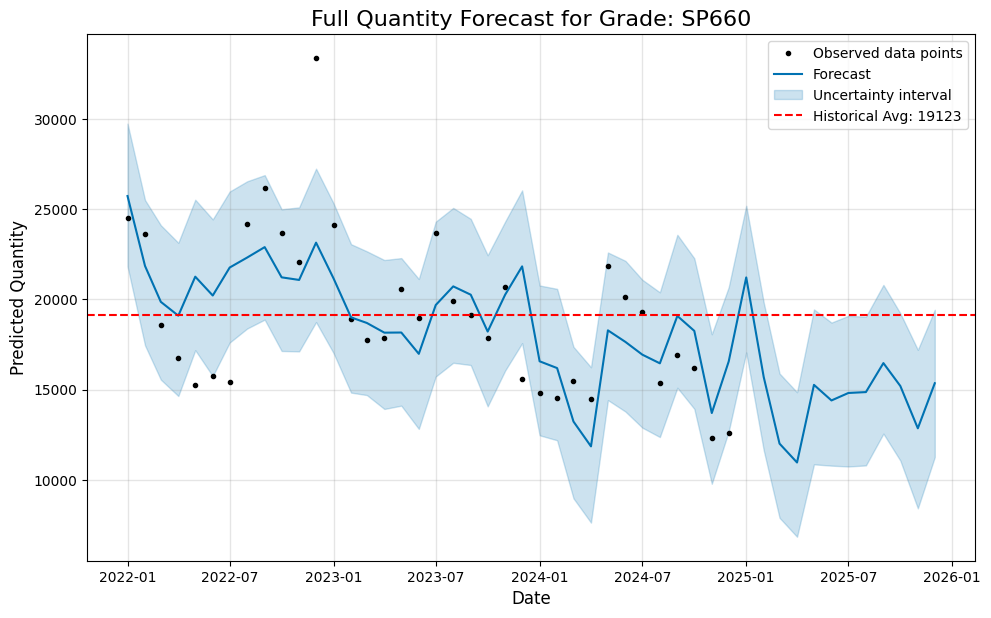

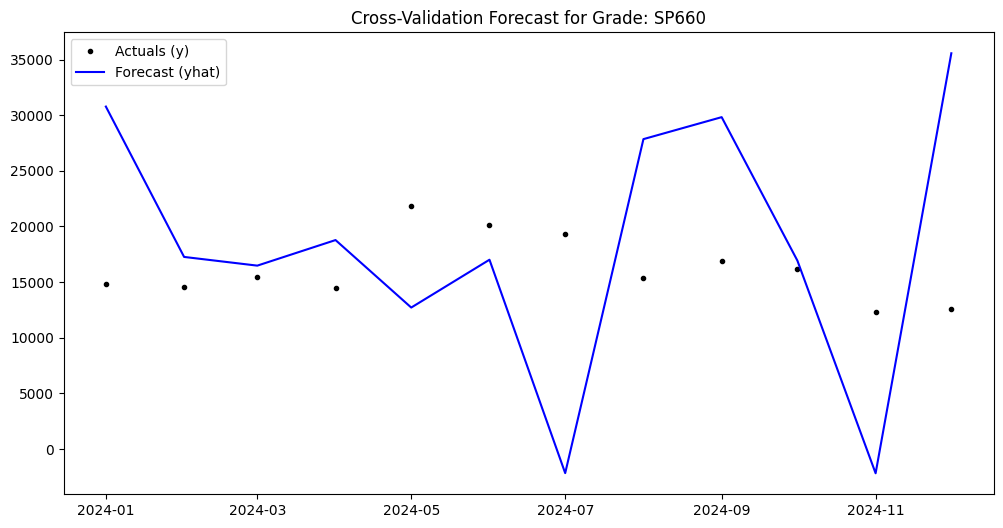

Displaying plot for TOP Grade: S199F


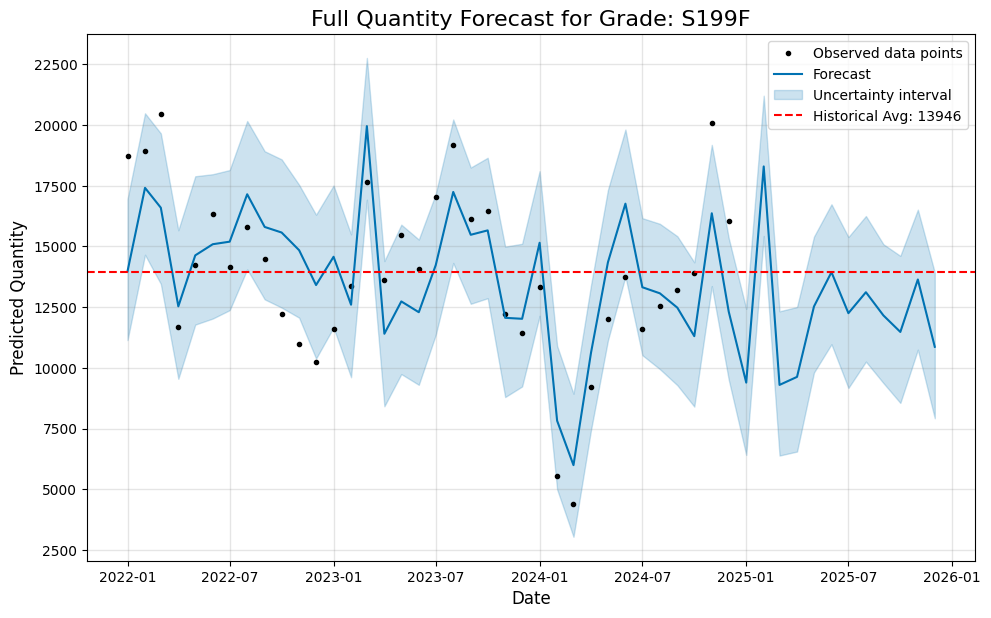

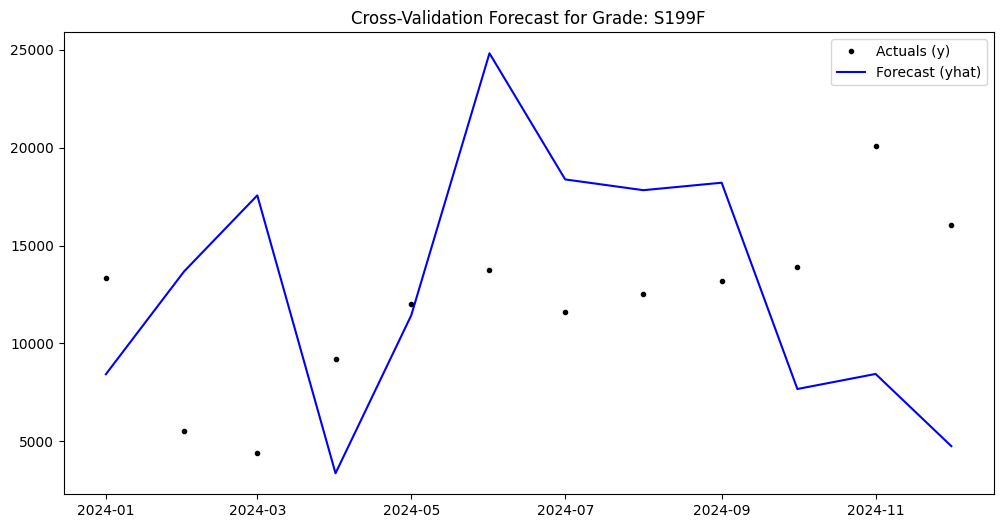

Displaying plot for TOP Grade: P601F


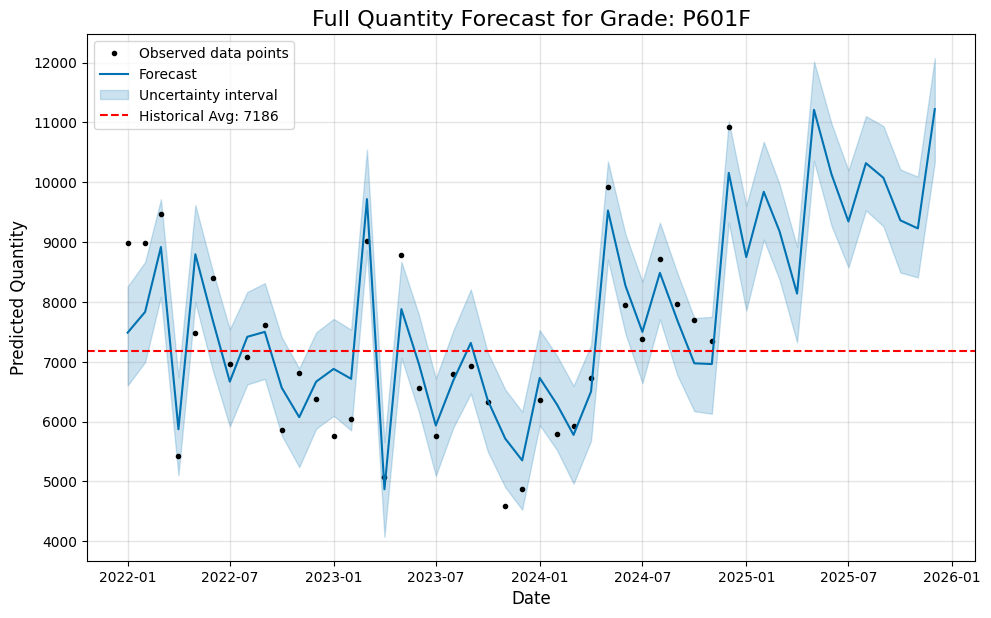

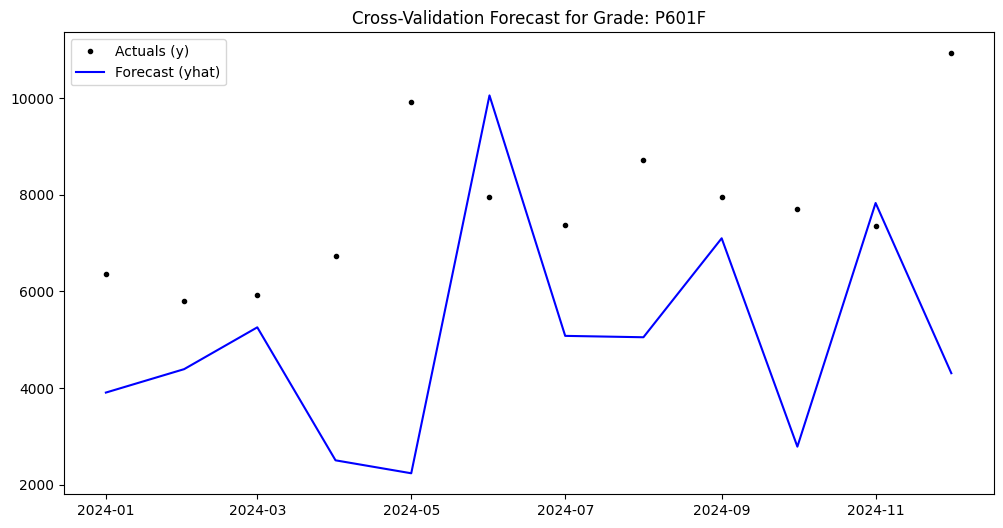

Displaying plot for TOP Grade: H112PC


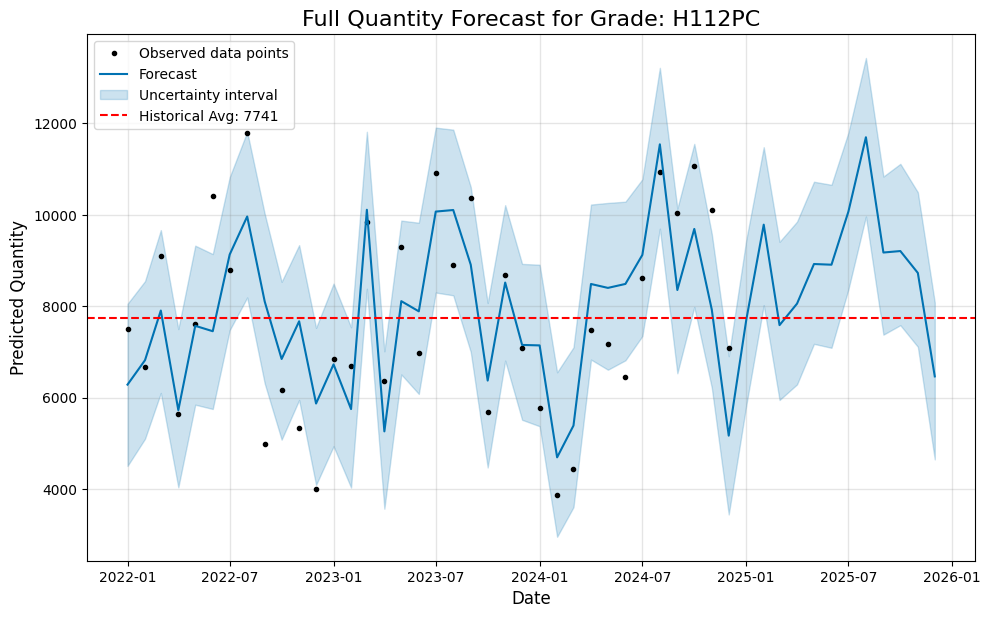

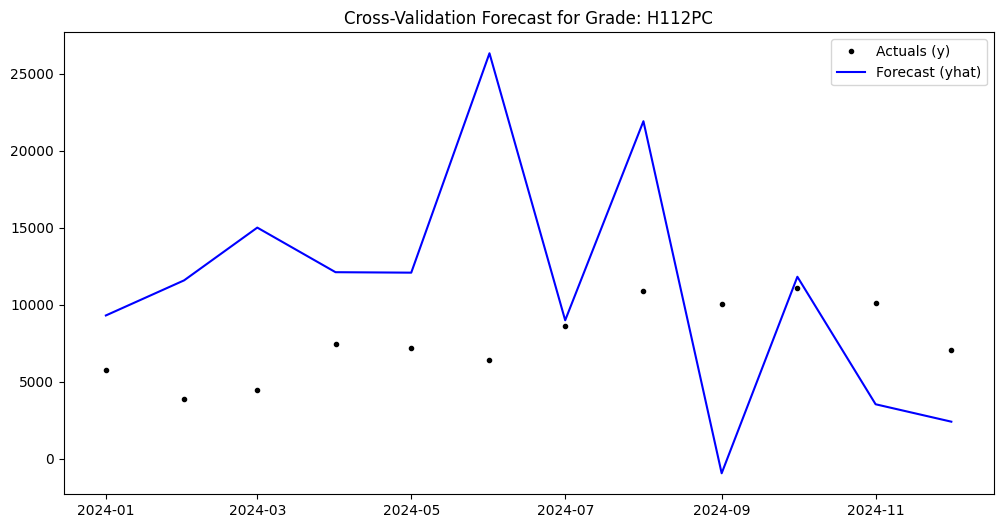

Displaying plot for TOP Grade: D777C


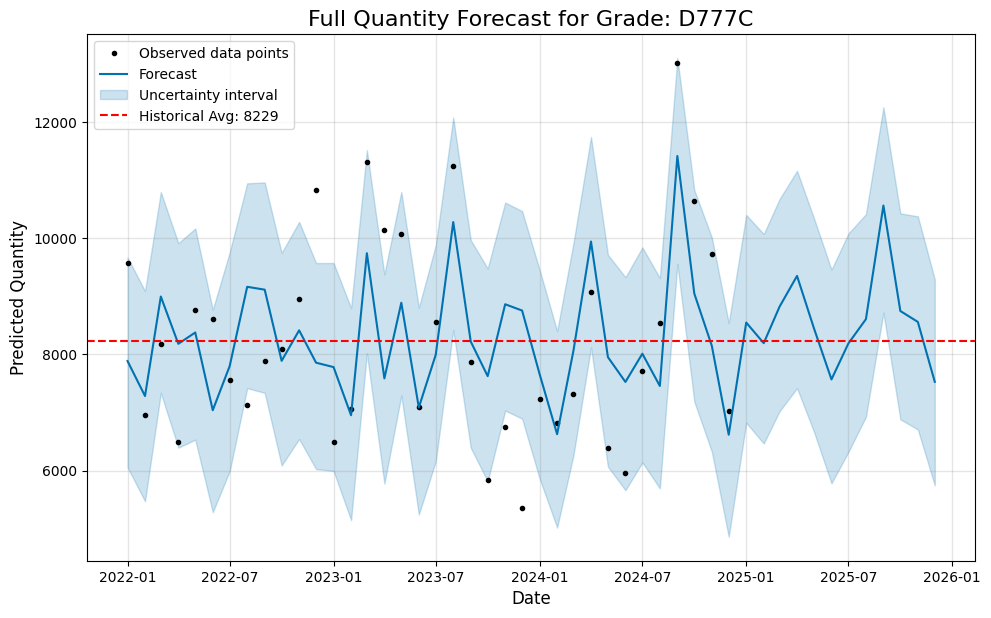

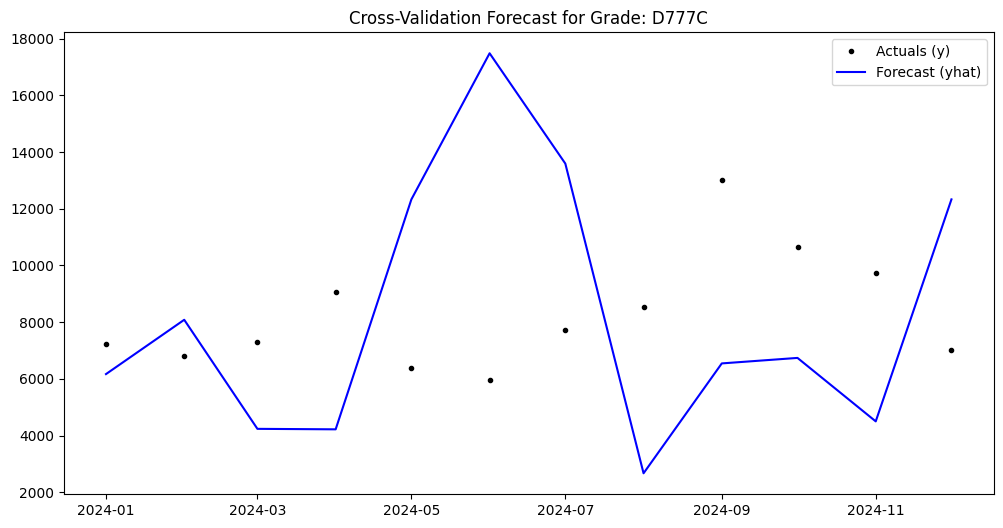

Displaying plot for TOP Grade: H1000PC


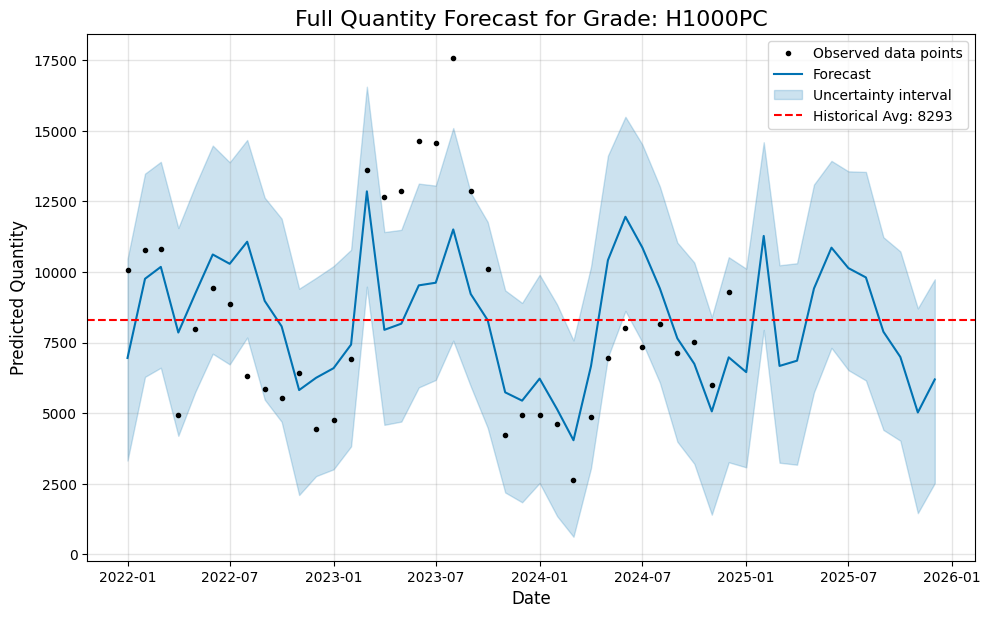

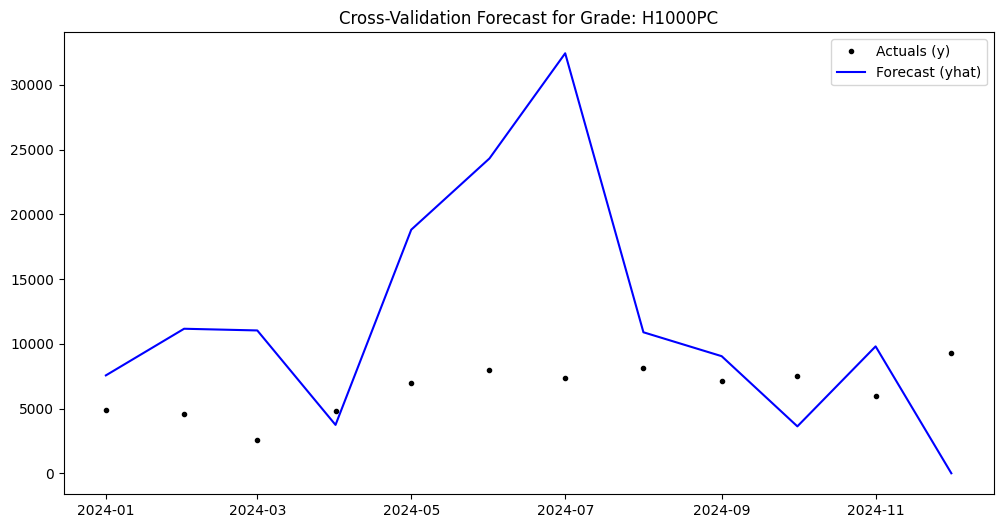

Displaying plot for TOP Grade: P400S


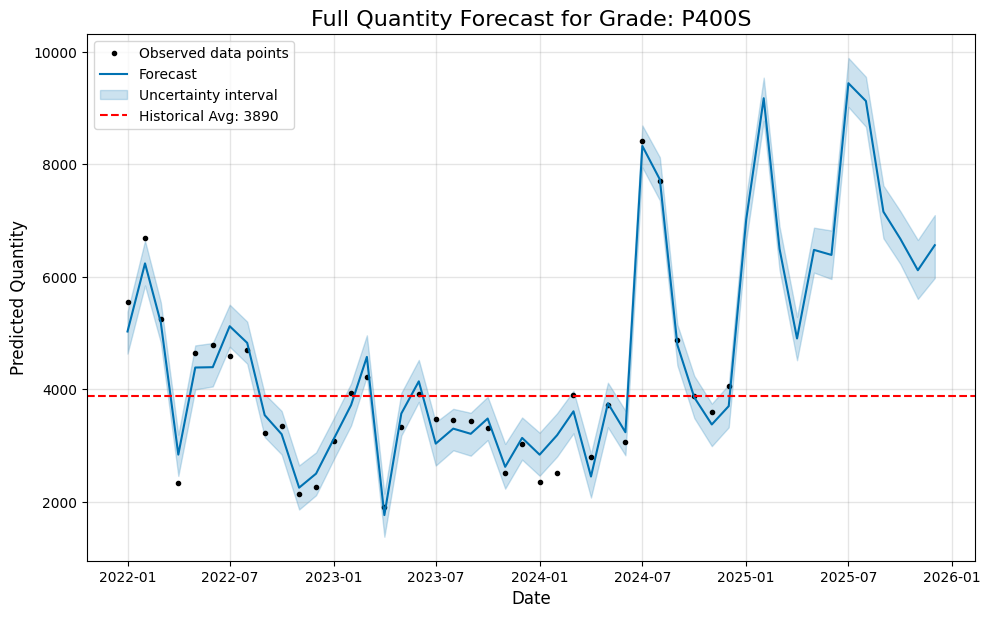

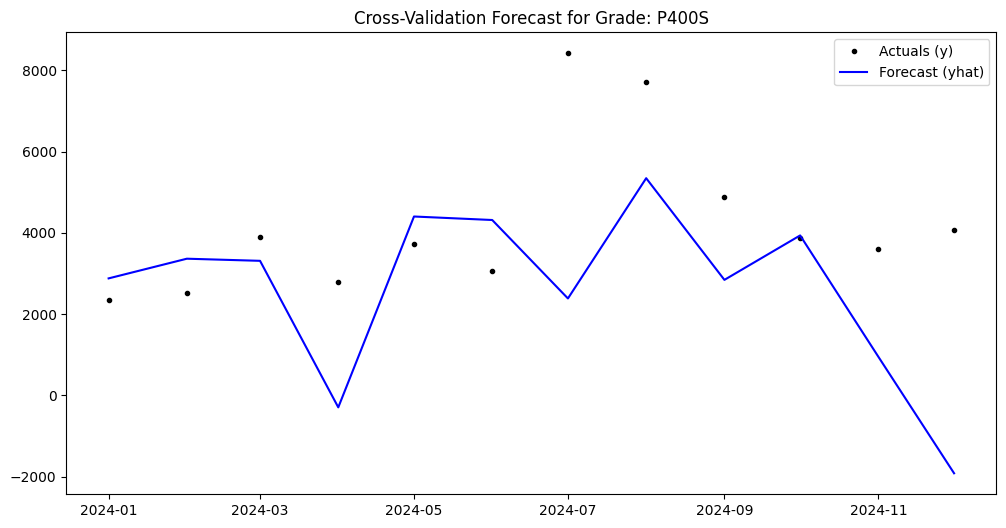

Displaying plot for TOP Grade: SG660


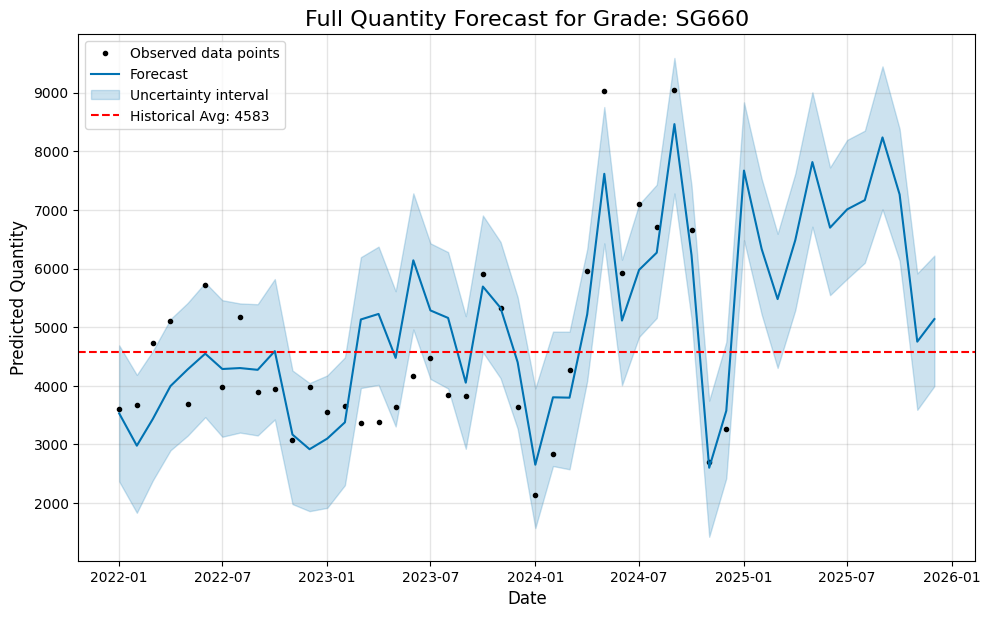

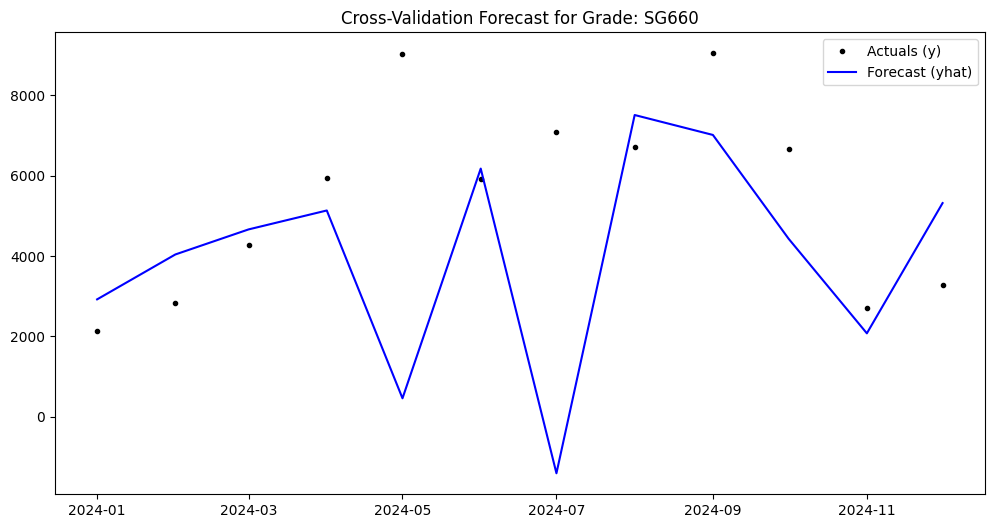

Displaying plot for TOP Grade: P842J


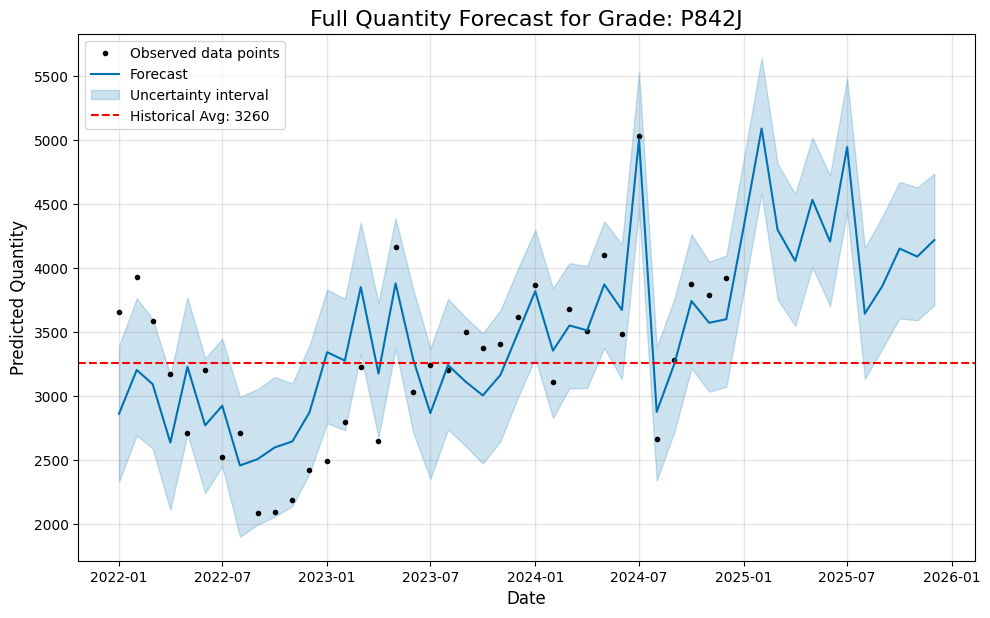

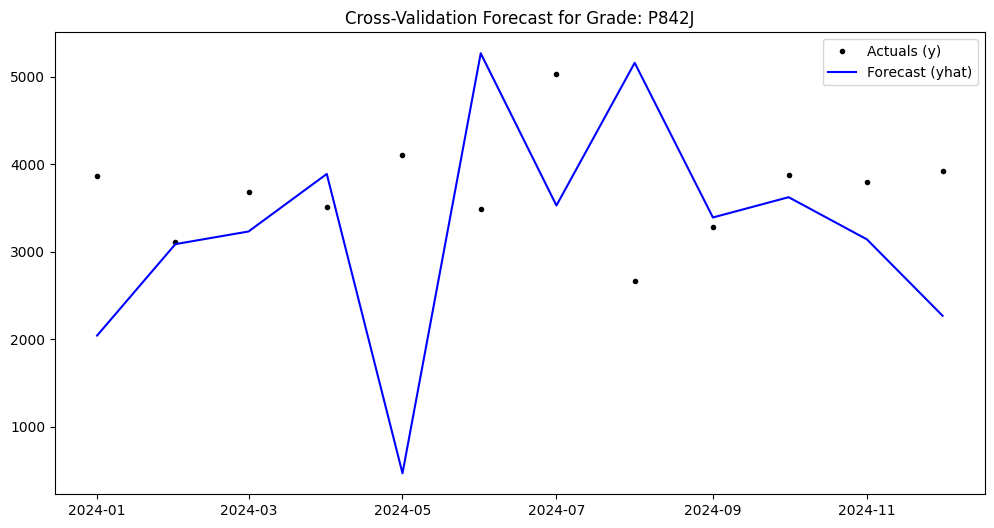

Displaying plot for TOP Grade: SG66J


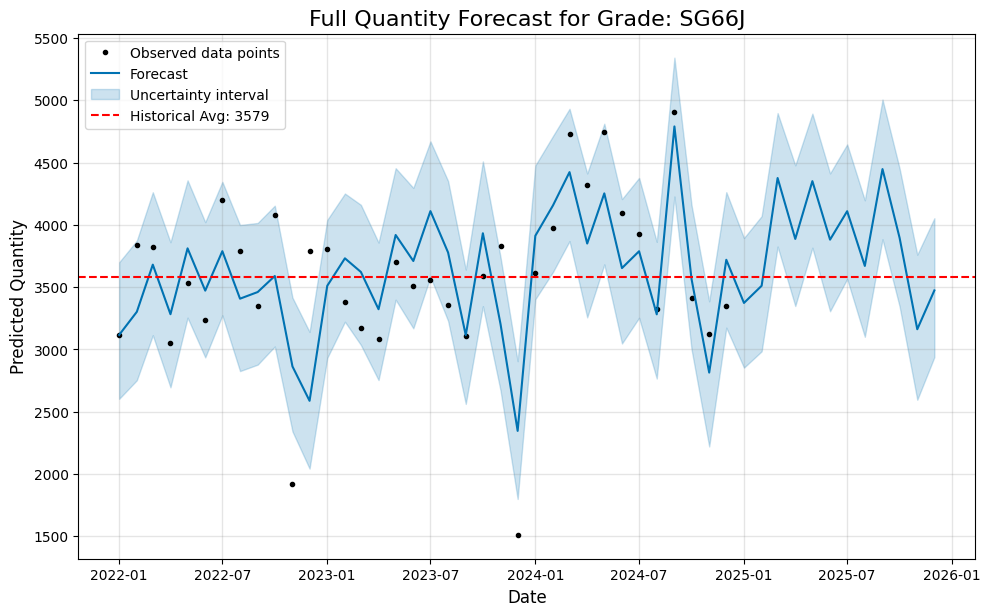

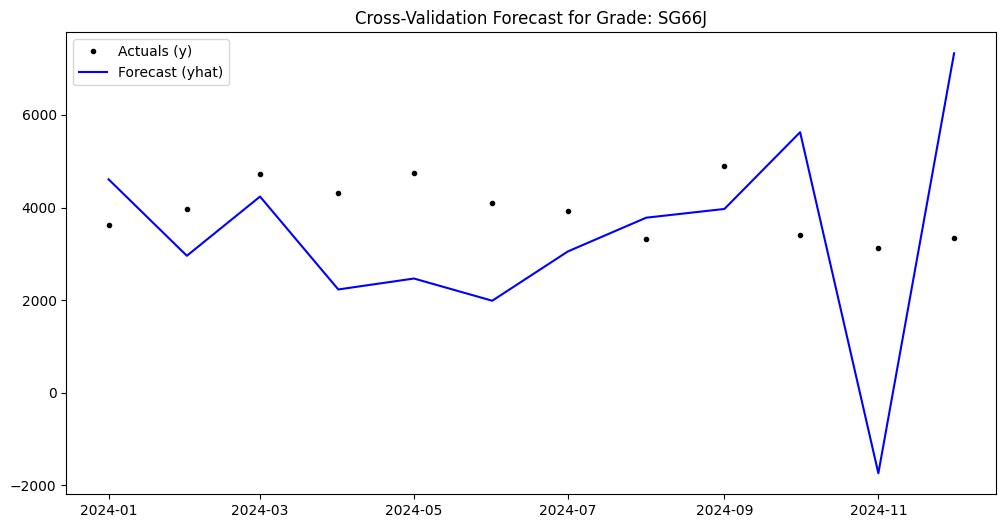

In [37]:
# ==============================================================================
# Step 8 (MODIFIED): Identify and Visualize Forecasts for TOP 10 GRADES
# ==============================================================================
print("\n--- Step 8: Identifying and Visualizing Forecasts for the Top 10 Grades ---")

# --- Part 1: Calculate Total Predicted Quantity for Each Grade ---
# This dictionary will store the total sum of 'yhat' for the next 12 months for each grade.
grade_total_forecasts = {}
last_known_date = complete_df['BillingDate'].max()

for grade, forecast in forecasts.items():
    # Isolate the 12 future prediction rows
    future_predictions = forecast[forecast['ds'] > last_known_date].copy()
    
    # Ensure predictions are not negative
    future_predictions['yhat'] = np.maximum(0, future_predictions['yhat'])
    
    # Calculate the sum of predicted quantities over the 12 months
    total_quantity = future_predictions['yhat'].sum()
    
    grade_total_forecasts[grade] = total_quantity

# --- Part 2: Rank the Grades and Select the Top 10 ---
# Convert the dictionary to a Pandas Series for easy sorting
totals_series = pd.Series(grade_total_forecasts)
top_10_grades_series = totals_series.sort_values(ascending=False).head(10)

print("🏆 Top 10 Grades by Total Predicted Quantity (Next 12 Months):")
# We print this list so you know which plots to expect
print(top_10_grades_series.round().astype(int))
print("-" * 50)
top_10_grade_names = top_10_grades_series.index.tolist()

# Calculate Accuracy using Cross-Validation for Top 10 Grades
# ==============================================================================
print("\n--- Step 8b: Calculating Model Accuracy via Cross-Validation ---")

# Import the necessary functions from Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# This will store the performance metrics for each top grade
all_performance_metrics = []

for grade in top_10_grade_names:
    print(f"\nRunning cross-validation for Grade: {grade}...")
    
    # Retrieve the trained model for the current grade
    model = models[grade]
    
    # Perform cross-validation. This simulates making forecasts on historical data.
    # initial: The size of the very first training period. We'll use 1.5 years.
    # period: The spacing between cutoff dates. We'll test every 6 months.
    # horizon: The length of the forecast to make from each cutoff. We'll test 6 months ahead.
    # NOTE: This can be slow, especially with many models.
    df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='180 days', parallel="processes")
    
    # Calculate the performance metrics from the cross-validation results
    df_p = performance_metrics(df_cv)
    
    # Add the grade name to the metrics dataframe for context
    df_p['Grade'] = grade
    all_performance_metrics.append(df_p)

# Combine all the performance metrics into a single DataFrame for a summary view
final_metrics_df = pd.concat(all_performance_metrics)

print("\n--- Cross-Validation Performance Summary (Averaged over 180-day horizon) ---")
# We only want to see the average metrics for each grade, not the metrics for every single day in the horizon.
# So we group by grade and take the mean.
summary_metrics = final_metrics_df.groupby('Grade')[['mae', 'rmse', 'mape']].mean().reset_index()

# Sort the summary by the original top 10 ranking for consistency
summary_metrics['Grade'] = pd.Categorical(summary_metrics['Grade'], categories=top_10_grade_names, ordered=True)
summary_metrics = summary_metrics.sort_values('Grade')

# Format the output for better readability
summary_metrics['mape'] = summary_metrics['mape'].apply(lambda x: f"{x:.2%}") # Format as percentage

print(summary_metrics.to_string(index=False))
print("-" * 50)

# Get the list of names of our top 10 grades
top_10_grade_names = top_10_grades_series.index.tolist()

# --- Part 3: Visualize the Full Forecast for ONLY the Top 10 Grades ---
print("\nGenerating individual forecast plots for each of the top 10 grades...")

# Loop through ONLY the top 10 grade names
for grade in top_10_grade_names:
    print(f"Displaying plot for TOP Grade: {grade}")
    
    # Retrieve the correct model and forecast data for this specific grade
    model = models[grade]
    forecast_data = forecasts[grade]
    df_cv = cross_validation(model, initial='547 days', period='180 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv)


    # Prophet's built-in plotting function is used here
    # It shows historical points, the forecast line, and the uncertainty interval.
    fig = model.plot(forecast_data)
    plt.title(f'Full Quantity Forecast for Grade: {grade}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Predicted Quantity', fontsize=12)
    
    # Add a horizontal line for the average historical sales for context
    # We need to get the historical data for this specific grade first
    historical_y = prophet_df = complete_df[complete_df['Grade'] == grade]['Quantity']
    plt.axhline(y=historical_y.mean(), color='r', linestyle='--', 
    label=f'Historical Avg: {historical_y.mean():.0f}')
    plt.legend()

    plt.show()

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(df_cv['ds'], df_cv['y'], 'k.', label='Actuals (y)')
    ax.plot(df_cv['ds'], df_cv['yhat'], ls='-', c='blue', label='Forecast (yhat)')
    ax.set_title(f'Cross-Validation Forecast for Grade: {grade}')
    ax.legend()
    plt.show()




--- Preparing to Tune Grade: P400S ---

--- Running a manually tuned model based on visual diagnosis ---


10:29:13 - cmdstanpy - INFO - Chain [1] start processing
10:29:14 - cmdstanpy - INFO - Chain [1] done processing


Displaying the forecast from the MANUALLY TUNED model...


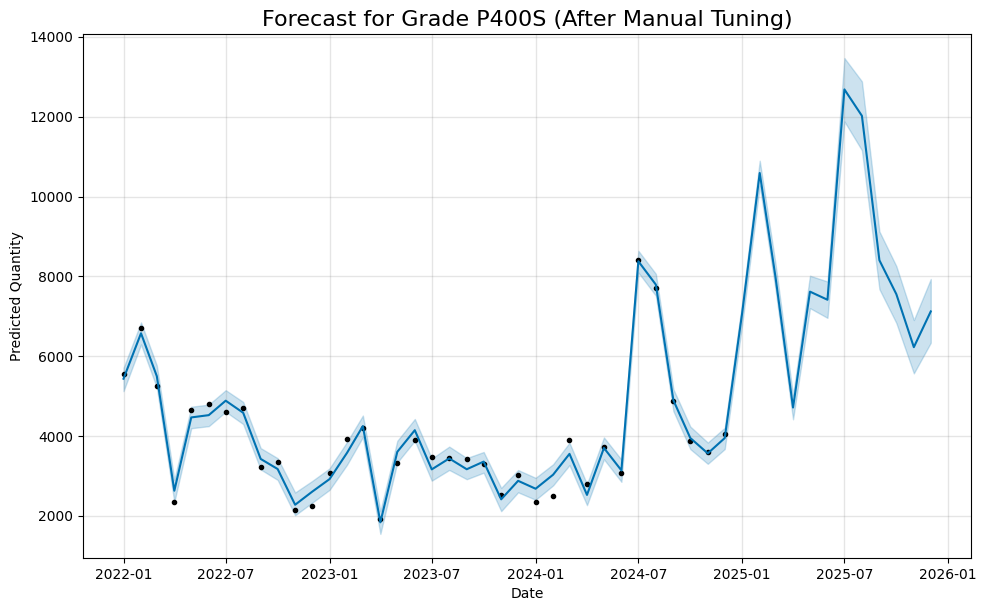


--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---


10:29:14 - cmdstanpy - INFO - Chain [1] start processing
10:29:15 - cmdstanpy - INFO - Chain [1] done processing



Baseline RMSE (Default Model): 2357.93

--- Starting Automated Grid Search for P400S to find the best combination ---
⚠️ This process can be slow.
Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:29:37 - cmdstanpy - INFO - Chain [1] start processing
10:29:38 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:30:01 - cmdstanpy - INFO - Chain [1] start processing
10:30:01 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:30:25 - cmdstanpy - INFO - Chain [1] start processing
10:30:26 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:30:47 - cmdstanpy - INFO - Chain [1] start processing
10:30:48 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:31:12 - cmdstanpy - INFO - Chain [1] start processing
10:31:13 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:31:35 - cmdstanpy - INFO - Chain [1] start processing
10:31:36 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:32:08 - cmdstanpy - INFO - Chain [1] start processing
10:32:08 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:32:33 - cmdstanpy - INFO - Chain [1] start processing
10:32:34 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:32:57 - cmdstanpy - INFO - Chain [1] start processing
10:32:57 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:33:19 - cmdstanpy - INFO - Chain [1] start processing
10:33:20 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:33:37 - cmdstanpy - INFO - Chain [1] start processing
10:33:38 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:34:01 - cmdstanpy - INFO - Chain [1] start processing
10:34:02 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:34:25 - cmdstanpy - INFO - Chain [1] start processing
10:34:26 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:34:51 - cmdstanpy - INFO - Chain [1] start processing
10:34:51 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:35:20 - cmdstanpy - INFO - Chain [1] start processing
10:35:21 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:47 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:36:16 - cmdstanpy - INFO - Chain [1] start processing
10:36:16 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:45 - cmdstanpy - INFO - Chain [1] done processing



--- Grid Search Results ---
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
13                     0.50                     10.0   multiplicative   
17                     0.50                     30.0   multiplicative   
15                     0.50                     20.0   multiplicative   
7                      0.10                     10.0   multiplicative   
11                     0.10                     30.0   multiplicative   
1                      0.05                     10.0   multiplicative   
5                      0.05                     30.0   multiplicative   
9                      0.10                     20.0   multiplicative   
3                      0.05                     20.0   multiplicative   
2                      0.05                     20.0         additive   
12                     0.50                     10.0         additive   
0                      0.05                     10.0         additive   
10                    

10:37:18 - cmdstanpy - INFO - Chain [1] start processing
10:37:19 - cmdstanpy - INFO - Chain [1] done processing



--- Before vs. After Tuning Comparison ---
Default Model RMSE: 2357.93
Tuned Model RMSE:   1434.81

Improvement: 39.15%
Conclusion: The tuned model is significantly BETTER.


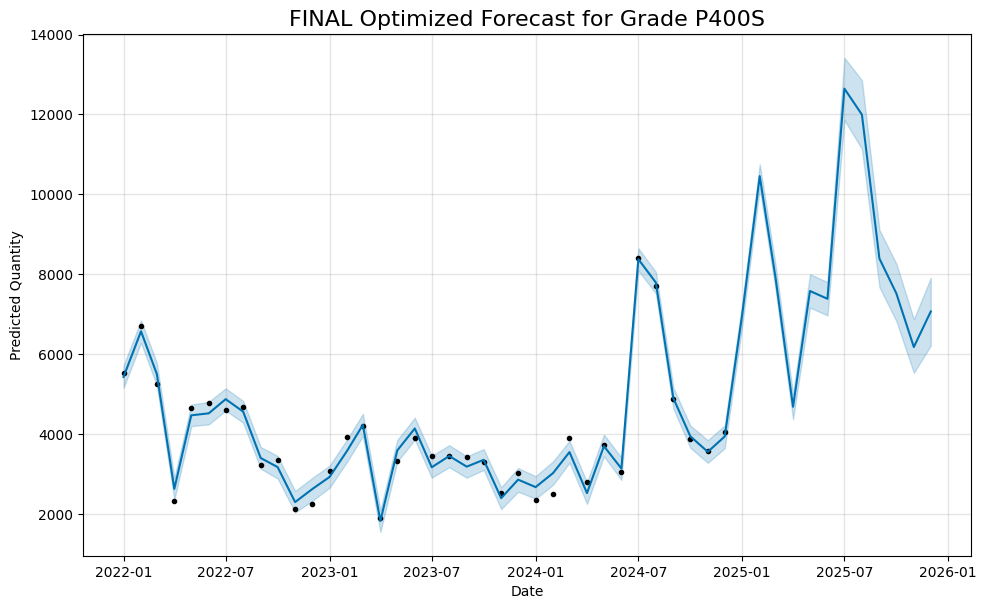

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# --- Assume 'complete_df' is already created from your previous code ---
# Let's make sure it exists, or create a dummy one for demonstration
try:
    _ = complete_df
except NameError:
    print("Creating dummy data as 'complete_df' was not found.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2024-12-31', freq='MS'))
    noise = np.random.normal(0, 500, len(dates))
    seasonal_pattern = 3000 * (1 + np.sin(dates.month * 2 * np.pi / 12 - np.pi/2))
    growing_trend = np.linspace(1000, 4000, len(dates))
    y = seasonal_pattern + growing_trend + noise
    y = np.maximum(0, y) # Ensure no negative sales
    complete_df = pd.DataFrame({'BillingDate': dates, 'Grade': 'P400S', 'Quantity': y})


# --- Step 1: Isolate the data for the specific grade ---
grade_to_tune = 'P400S'
prophet_df = complete_df[complete_df['Grade'] == grade_to_tune][['BillingDate', 'Quantity']].rename(
    columns={'BillingDate': 'ds', 'Quantity': 'y'}
)
print(f"--- Preparing to Tune Grade: {grade_to_tune} ---")


# --- Step 2: Run a manual, targeted tuning based on our diagnosis ---
print("\n--- Running a manually tuned model based on visual diagnosis ---")

# Initialize the model with our chosen "smarter" hyperparameters
tuned_model = Prophet(
    seasonality_mode='multiplicative', # ADDRESSES the growing seasonal swings
    seasonality_prior_scale=25.0,      # ADDRESSES the underfitting of peaks/troughs
    changepoint_prior_scale=0.5        # ADDRESSES the volatile trend
)
tuned_model.fit(prophet_df)

# Create a future dataframe and make a prediction
future = tuned_model.make_future_dataframe(periods=12, freq='MS')
tuned_forecast = tuned_model.predict(future)

# Plot the forecast from our new tuned model
print("Displaying the forecast from the MANUALLY TUNED model...")
fig = tuned_model.plot(tuned_forecast)
plt.title(f'Forecast for Grade {grade_to_tune} (After Manual Tuning)', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()

# --- ADD THIS NEW SECTION BEFORE YOUR GRID SEARCH ---

# --- Step 2b: Get the "Before" score from the default model ---
print("\n--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---")

# Initialize a default Prophet model (no special parameters)
default_model = Prophet()
default_model.fit(prophet_df)

# Run the EXACT SAME cross-validation as your grid search
df_cv_default = cross_validation(default_model, initial='547 days', period='90 days', horizon='180 days', parallel="processes")
df_p_default = performance_metrics(df_cv_default)

# Get the baseline RMSE
baseline_rmse = df_p_default['rmse'].mean()
print(f"\nBaseline RMSE (Default Model): {baseline_rmse:.2f}")

# -----------------------------------------------------------------


# --- Step 3: Find the OPTIMAL parameters using automated Grid Search ---
print(f"\n--- Starting Automated Grid Search for {grade_to_tune} to find the best combination ---")
print("⚠️ This process can be slow.")

param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 20.0, 30.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Loop through each combination of parameters
for params in all_params:
    print(f"Testing params: {params}")
    m = Prophet(**params).fit(prophet_df)
    df_cv = cross_validation(m, initial='547 days', period='90 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print("\n--- Grid Search Results ---")
print(tuning_results.sort_values('rmse'))
best_rmse = min(rmses)
best_params = all_params[np.argmin(rmses)]
print(f'\n🏆 Best Parameters Found: {best_params}')


# --- Step 4: Train and Plot the FINAL optimized model ---
print("\n--- Training and visualizing the FINAL model with the best parameters ---")
final_model = Prophet(**best_params).fit(prophet_df)
final_future = final_model.make_future_dataframe(periods=12, freq='MS')
final_forecast = final_model.predict(final_future)
print("\n--- Before vs. After Tuning Comparison ---")
print(f"Default Model RMSE: {baseline_rmse:.2f}")
print(f"Tuned Model RMSE:   {best_rmse:.2f}")

improvement_percent = ((baseline_rmse - best_rmse) / baseline_rmse) * 100
print(f"\nImprovement: {improvement_percent:.2f}%")

if improvement_percent > 0:
    print("Conclusion: The tuned model is significantly BETTER.")
else:
    print("Conclusion: Tuning did not improve the model (this is rare).")
# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title(f'FINAL Optimized Forecast for Grade {grade_to_tune}', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()

--- Preparing to Tune Grade: P400S ---

--- Running a manually tuned model based on visual diagnosis ---


10:37:20 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing


Displaying the forecast from the MANUALLY TUNED model...


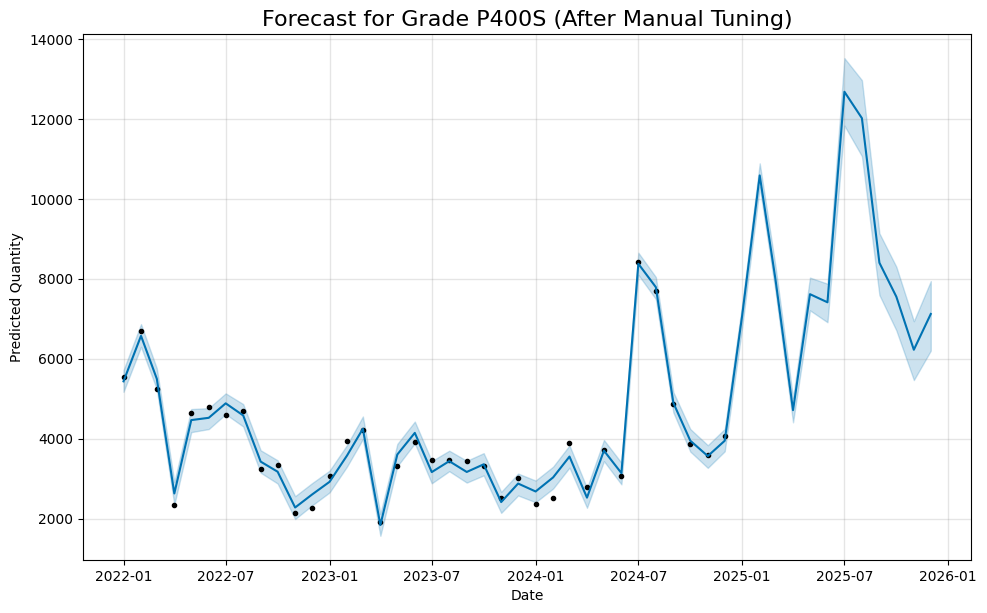


--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---


10:37:22 - cmdstanpy - INFO - Chain [1] start processing
10:37:23 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing



Baseline RMSE (Default Model): 2172.39

--- Starting Automated Grid Search for P400S to find the best combination ---
⚠️ This process can be slow.
Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:37:45 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:38:05 - cmdstanpy - INFO - Chain [1] start processing
10:38:05 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:38:25 - cmdstanpy - INFO - Chain [1] start processing
10:38:25 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:38:45 - cmdstanpy - INFO - Chain [1] start processing
10:38:45 - cmdstanpy - INFO - Chain [1] done processing
10:39:05 - cmdstanpy - INFO - Chain [1] start processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:39:05 - cmdstanpy - INFO - Chain [1] done processing
10:39:23 - cmdstanpy - INFO - Chain [1] start processing


Testing params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:39:24 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:39:43 - cmdstanpy - INFO - Chain [1] start processing
10:39:44 - cmdstanpy - INFO - Chain [1] done processing
10:40:03 - cmdstanpy - INFO - Chain [1] start processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:40:03 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:40:23 - cmdstanpy - INFO - Chain [1] start processing
10:40:23 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:40:55 - cmdstanpy - INFO - Chain [1] start processing
10:40:56 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:17 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:41:42 - cmdstanpy - INFO - Chain [1] start processing
10:41:43 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


10:42:08 - cmdstanpy - INFO - Chain [1] start processing
10:42:09 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


10:42:39 - cmdstanpy - INFO - Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'additive'}


10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:14 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}


10:43:46 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'additive'}


10:44:28 - cmdstanpy - INFO - Chain [1] start processing
10:44:29 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 30.0, 'seasonality_mode': 'multiplicative'}


10:44:57 - cmdstanpy - INFO - Chain [1] start processing
10:44:58 - cmdstanpy - INFO - Chain [1] done processing



--- Grid Search Results ---
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
13                     0.50                     10.0   multiplicative   
17                     0.50                     30.0   multiplicative   
15                     0.50                     20.0   multiplicative   
7                      0.10                     10.0   multiplicative   
11                     0.10                     30.0   multiplicative   
1                      0.05                     10.0   multiplicative   
5                      0.05                     30.0   multiplicative   
9                      0.10                     20.0   multiplicative   
3                      0.05                     20.0   multiplicative   
2                      0.05                     20.0         additive   
12                     0.50                     10.0         additive   
0                      0.05                     10.0         additive   
10                    

10:45:30 - cmdstanpy - INFO - Chain [1] start processing
10:45:30 - cmdstanpy - INFO - Chain [1] done processing



--- Before vs. After Tuning Comparison ---
Default Model RMSE: 2172.39
Tuned Model RMSE:   1434.81

Improvement: 33.95%
Conclusion: The tuned model is significantly BETTER.


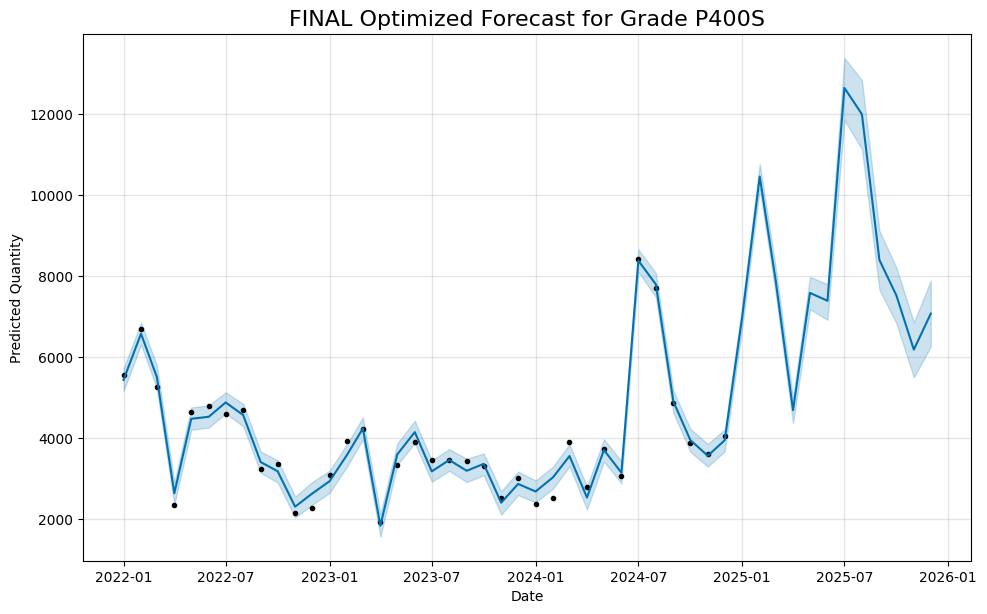

In [39]:
## Try period = 180 days
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# --- Assume 'complete_df' is already created from your previous code ---
# Let's make sure it exists, or create a dummy one for demonstration
try:
    _ = complete_df
except NameError:
    print("Creating dummy data as 'complete_df' was not found.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2024-12-31', freq='MS'))
    noise = np.random.normal(0, 500, len(dates))
    seasonal_pattern = 3000 * (1 + np.sin(dates.month * 2 * np.pi / 12 - np.pi/2))
    growing_trend = np.linspace(1000, 4000, len(dates))
    y = seasonal_pattern + growing_trend + noise
    y = np.maximum(0, y) # Ensure no negative sales
    complete_df = pd.DataFrame({'BillingDate': dates, 'Grade': 'P400S', 'Quantity': y})


# --- Step 1: Isolate the data for the specific grade ---
grade_to_tune = 'P400S'
prophet_df = complete_df[complete_df['Grade'] == grade_to_tune][['BillingDate', 'Quantity']].rename(
    columns={'BillingDate': 'ds', 'Quantity': 'y'}
)
print(f"--- Preparing to Tune Grade: {grade_to_tune} ---")


# --- Step 2: Run a manual, targeted tuning based on our diagnosis ---
print("\n--- Running a manually tuned model based on visual diagnosis ---")

# Initialize the model with our chosen "smarter" hyperparameters
tuned_model = Prophet(
    seasonality_mode='multiplicative', # ADDRESSES the growing seasonal swings
    seasonality_prior_scale=25.0,      # ADDRESSES the underfitting of peaks/troughs
    changepoint_prior_scale=0.5        # ADDRESSES the volatile trend
)
tuned_model.fit(prophet_df)

# Create a future dataframe and make a prediction
future = tuned_model.make_future_dataframe(periods=12, freq='MS')
tuned_forecast = tuned_model.predict(future)

# Plot the forecast from our new tuned model
print("Displaying the forecast from the MANUALLY TUNED model...")
fig = tuned_model.plot(tuned_forecast)
plt.title(f'Forecast for Grade {grade_to_tune} (After Manual Tuning)', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()

# --- ADD THIS NEW SECTION BEFORE YOUR GRID SEARCH ---

# --- Step 2b: Get the "Before" score from the default model ---
print("\n--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---")

# Initialize a default Prophet model (no special parameters)
default_model = Prophet()
default_model.fit(prophet_df)

# Run the EXACT SAME cross-validation as your grid search
df_cv_default = cross_validation(default_model, initial='547 days', period='180 days', horizon='180 days', parallel="processes")
df_p_default = performance_metrics(df_cv_default)

# Get the baseline RMSE
baseline_rmse = df_p_default['rmse'].mean()
print(f"\nBaseline RMSE (Default Model): {baseline_rmse:.2f}")

# -----------------------------------------------------------------


# --- Step 3: Find the OPTIMAL parameters using automated Grid Search ---
print(f"\n--- Starting Automated Grid Search for {grade_to_tune} to find the best combination ---")
print("⚠️ This process can be slow.")

param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 20.0, 30.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Loop through each combination of parameters
for params in all_params:
    print(f"Testing params: {params}")
    m = Prophet(**params).fit(prophet_df)
    df_cv = cross_validation(m, initial='547 days', period='90 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print("\n--- Grid Search Results ---")
print(tuning_results.sort_values('rmse'))
best_rmse = min(rmses)
best_params = all_params[np.argmin(rmses)]
print(f'\n🏆 Best Parameters Found: {best_params}')


# --- Step 4: Train and Plot the FINAL optimized model ---
print("\n--- Training and visualizing the FINAL model with the best parameters ---")
final_model = Prophet(**best_params).fit(prophet_df)
final_future = final_model.make_future_dataframe(periods=12, freq='MS')
final_forecast = final_model.predict(final_future)
print("\n--- Before vs. After Tuning Comparison ---")
print(f"Default Model RMSE: {baseline_rmse:.2f}")
print(f"Tuned Model RMSE:   {best_rmse:.2f}")

improvement_percent = ((baseline_rmse - best_rmse) / baseline_rmse) * 100
print(f"\nImprovement: {improvement_percent:.2f}%")

if improvement_percent > 0:
    print("Conclusion: The tuned model is significantly BETTER.")
else:
    print("Conclusion: Tuning did not improve the model (this is rare).")
# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title(f'FINAL Optimized Forecast for Grade {grade_to_tune}', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()

--- Preparing to Tune Grade: P400S ---

--- Running a manually tuned model based on visual diagnosis ---


10:58:22 - cmdstanpy - INFO - Chain [1] start processing
10:58:22 - cmdstanpy - INFO - Chain [1] done processing


Displaying the forecast from the MANUALLY TUNED model...


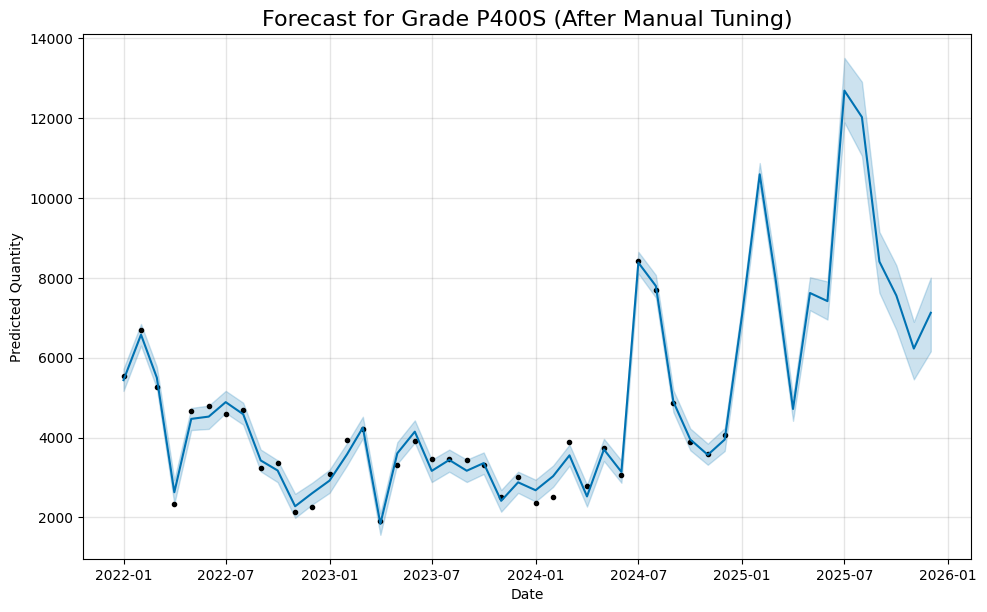


--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---


10:58:23 - cmdstanpy - INFO - Chain [1] start processing
10:58:23 - cmdstanpy - INFO - Chain [1] done processing



Baseline RMSE (Default Model): 2172.39

--- Starting Automated Grid Search for P400S to find the best combination ---
⚠️ This process can be slow.
Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'additive'}


10:58:41 - cmdstanpy - INFO - Chain [1] start processing
10:58:41 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'multiplicative'}


10:59:02 - cmdstanpy - INFO - Chain [1] start processing
10:59:03 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'additive'}


10:59:27 - cmdstanpy - INFO - Chain [1] start processing
10:59:28 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'multiplicative'}


10:59:49 - cmdstanpy - INFO - Chain [1] start processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'additive'}


11:00:15 - cmdstanpy - INFO - Chain [1] start processing
11:00:15 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'multiplicative'}


11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:37 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


11:01:02 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


11:01:23 - cmdstanpy - INFO - Chain [1] start processing
11:01:24 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'additive'}


11:01:49 - cmdstanpy - INFO - Chain [1] start processing
11:01:50 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'multiplicative'}


11:02:12 - cmdstanpy - INFO - Chain [1] start processing
11:02:13 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'additive'}


11:02:39 - cmdstanpy - INFO - Chain [1] start processing
11:02:39 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'multiplicative'}


11:03:01 - cmdstanpy - INFO - Chain [1] start processing
11:03:02 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'additive'}


11:03:30 - cmdstanpy - INFO - Chain [1] start processing
11:03:30 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'multiplicative'}


11:03:55 - cmdstanpy - INFO - Chain [1] start processing
11:03:56 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'additive'}


11:04:24 - cmdstanpy - INFO - Chain [1] start processing
11:04:24 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'multiplicative'}


11:04:46 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


11:05:14 - cmdstanpy - INFO - Chain [1] start processing
11:05:15 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


11:05:39 - cmdstanpy - INFO - Chain [1] start processing
11:05:40 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'additive'}


11:06:07 - cmdstanpy - INFO - Chain [1] start processing
11:06:08 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.4, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'multiplicative'}


11:06:33 - cmdstanpy - INFO - Chain [1] start processing
11:06:33 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'additive'}


11:07:03 - cmdstanpy - INFO - Chain [1] start processing
11:07:03 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'multiplicative'}


11:07:27 - cmdstanpy - INFO - Chain [1] start processing
11:07:28 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'additive'}


11:08:00 - cmdstanpy - INFO - Chain [1] start processing
11:08:01 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'multiplicative'}


11:08:26 - cmdstanpy - INFO - Chain [1] start processing
11:08:27 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'additive'}


11:08:59 - cmdstanpy - INFO - Chain [1] start processing
11:09:00 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'multiplicative'}


11:09:26 - cmdstanpy - INFO - Chain [1] start processing
11:09:27 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


11:09:58 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


11:10:25 - cmdstanpy - INFO - Chain [1] start processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'additive'}


11:10:59 - cmdstanpy - INFO - Chain [1] start processing
11:11:00 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'multiplicative'}


11:11:26 - cmdstanpy - INFO - Chain [1] start processing
11:11:27 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'additive'}


11:11:57 - cmdstanpy - INFO - Chain [1] start processing
11:11:58 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'multiplicative'}


11:12:30 - cmdstanpy - INFO - Chain [1] start processing
11:12:31 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'additive'}


11:13:02 - cmdstanpy - INFO - Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'multiplicative'}


11:13:33 - cmdstanpy - INFO - Chain [1] start processing
11:13:34 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'additive'}


11:14:07 - cmdstanpy - INFO - Chain [1] start processing
11:14:07 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'multiplicative'}


11:14:37 - cmdstanpy - INFO - Chain [1] start processing
11:14:38 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


11:15:10 - cmdstanpy - INFO - Chain [1] start processing
11:15:11 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


11:15:38 - cmdstanpy - INFO - Chain [1] start processing
11:15:39 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'additive'}


11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:11 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'multiplicative'}


11:16:42 - cmdstanpy - INFO - Chain [1] start processing
11:16:44 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'additive'}


11:17:16 - cmdstanpy - INFO - Chain [1] start processing
11:17:17 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 4.0, 'seasonality_mode': 'multiplicative'}


11:17:49 - cmdstanpy - INFO - Chain [1] start processing
11:17:49 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'additive'}


11:18:20 - cmdstanpy - INFO - Chain [1] start processing
11:18:21 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 6.0, 'seasonality_mode': 'multiplicative'}


11:18:53 - cmdstanpy - INFO - Chain [1] start processing
11:18:54 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'additive'}


11:19:25 - cmdstanpy - INFO - Chain [1] start processing
11:19:26 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 8.0, 'seasonality_mode': 'multiplicative'}


11:19:57 - cmdstanpy - INFO - Chain [1] start processing
11:19:58 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


11:20:29 - cmdstanpy - INFO - Chain [1] start processing
11:20:30 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


11:21:00 - cmdstanpy - INFO - Chain [1] start processing
11:21:01 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'additive'}


11:21:33 - cmdstanpy - INFO - Chain [1] start processing
11:21:34 - cmdstanpy - INFO - Chain [1] done processing


Testing params: {'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 12.0, 'seasonality_mode': 'multiplicative'}


11:22:06 - cmdstanpy - INFO - Chain [1] start processing
11:22:07 - cmdstanpy - INFO - Chain [1] done processing



--- Grid Search Results ---
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
27                      0.5                     10.0   multiplicative   
47                      0.7                     10.0   multiplicative   
25                      0.5                      8.0   multiplicative   
39                      0.6                     12.0   multiplicative   
37                      0.6                     10.0   multiplicative   
49                      0.7                     12.0   multiplicative   
11                      0.4                      4.0   multiplicative   
15                      0.4                      8.0   multiplicative   
22                      0.5                      6.0         additive   
12                      0.4                      6.0         additive   
21                      0.5                      4.0   multiplicative   
31                      0.6                      4.0   multiplicative   
1                     

11:22:37 - cmdstanpy - INFO - Chain [1] start processing
11:22:38 - cmdstanpy - INFO - Chain [1] done processing



--- Before vs. After Tuning Comparison ---
Default Model RMSE: 2172.39
Tuned Model RMSE:   1434.81

Improvement: 33.95%
Conclusion: The tuned model is significantly BETTER.


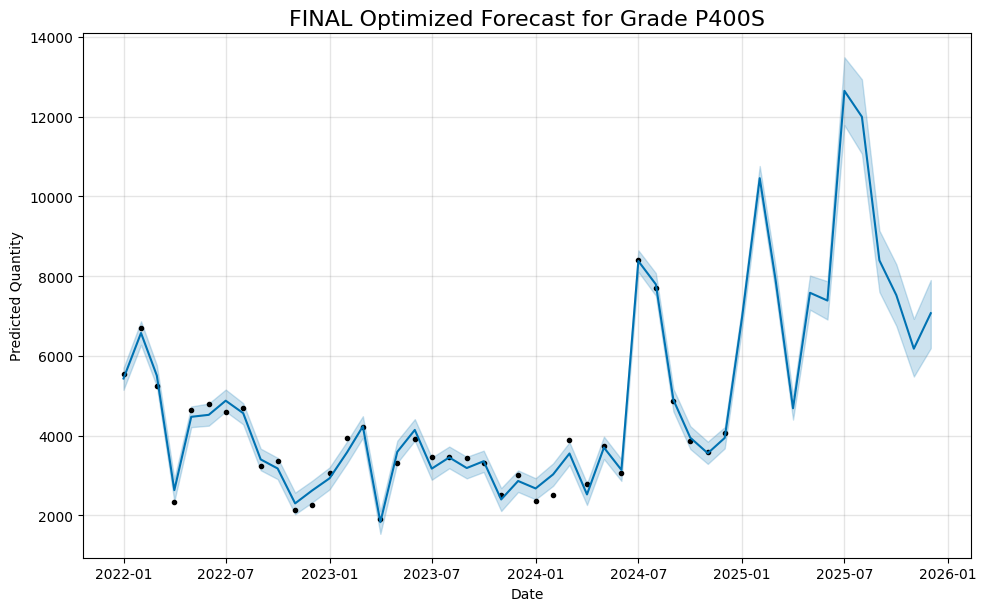

In [41]:
## Try period = 180 days
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# --- Assume 'complete_df' is already created from your previous code ---
# Let's make sure it exists, or create a dummy one for demonstration
try:
    _ = complete_df
except NameError:
    print("Creating dummy data as 'complete_df' was not found.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2024-12-31', freq='MS'))
    noise = np.random.normal(0, 500, len(dates))
    seasonal_pattern = 3000 * (1 + np.sin(dates.month * 2 * np.pi / 12 - np.pi/2))
    growing_trend = np.linspace(1000, 4000, len(dates))
    y = seasonal_pattern + growing_trend + noise
    y = np.maximum(0, y) # Ensure no negative sales
    complete_df = pd.DataFrame({'BillingDate': dates, 'Grade': 'P400S', 'Quantity': y})


# --- Step 1: Isolate the data for the specific grade ---
grade_to_tune = 'P400S'
prophet_df = complete_df[complete_df['Grade'] == grade_to_tune][['BillingDate', 'Quantity']].rename(
    columns={'BillingDate': 'ds', 'Quantity': 'y'}
)
print(f"--- Preparing to Tune Grade: {grade_to_tune} ---")


# --- Step 2: Run a manual, targeted tuning based on our diagnosis ---
print("\n--- Running a manually tuned model based on visual diagnosis ---")

# Initialize the model with our chosen "smarter" hyperparameters
tuned_model = Prophet(
    seasonality_mode='multiplicative', # ADDRESSES the growing seasonal swings
    seasonality_prior_scale=25.0,      # ADDRESSES the underfitting of peaks/troughs
    changepoint_prior_scale=0.5        # ADDRESSES the volatile trend
)
tuned_model.fit(prophet_df)

# Create a future dataframe and make a prediction
future = tuned_model.make_future_dataframe(periods=12, freq='MS')
tuned_forecast = tuned_model.predict(future)

# Plot the forecast from our new tuned model
print("Displaying the forecast from the MANUALLY TUNED model...")
fig = tuned_model.plot(tuned_forecast)
plt.title(f'Forecast for Grade {grade_to_tune} (After Manual Tuning)', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()

# --- ADD THIS NEW SECTION BEFORE YOUR GRID SEARCH ---

# --- Step 2b: Get the "Before" score from the default model ---
print("\n--- Establishing a Baseline: Calculating accuracy of the DEFAULT model ---")

# Initialize a default Prophet model (no special parameters)
default_model = Prophet()
default_model.fit(prophet_df)

# Run the EXACT SAME cross-validation as your grid search
df_cv_default = cross_validation(default_model, initial='547 days', period='180 days', horizon='180 days', parallel="processes")
df_p_default = performance_metrics(df_cv_default)

# Get the baseline RMSE
baseline_rmse = df_p_default['rmse'].mean()
print(f"\nBaseline RMSE (Default Model): {baseline_rmse:.2f}")

# -----------------------------------------------------------------


# --- Step 3: Find the OPTIMAL parameters using automated Grid Search ---
print(f"\n--- Starting Automated Grid Search for {grade_to_tune} to find the best combination ---")
print("⚠️ This process can be slow.")

param_grid = {
    'changepoint_prior_scale': [0.3, 0.4, 0.5, 0.6, 0.7],
    'seasonality_prior_scale': [4.0, 6.0, 8.0, 10.0, 12.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

# Loop through each combination of parameters
for params in all_params:
    print(f"Testing params: {params}")
    m = Prophet(**params).fit(prophet_df)
    df_cv = cross_validation(m, initial='547 days', period='90 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print("\n--- Grid Search Results ---")
print(tuning_results.sort_values('rmse'))
best_rmse = min(rmses)
best_params = all_params[np.argmin(rmses)]
print(f'\n🏆 Best Parameters Found: {best_params}')


# --- Step 4: Train and Plot the FINAL optimized model ---
print("\n--- Training and visualizing the FINAL model with the best parameters ---")
final_model = Prophet(**best_params).fit(prophet_df)
final_future = final_model.make_future_dataframe(periods=12, freq='MS')
final_forecast = final_model.predict(final_future)
print("\n--- Before vs. After Tuning Comparison ---")
print(f"Default Model RMSE: {baseline_rmse:.2f}")
print(f"Tuned Model RMSE:   {best_rmse:.2f}")

improvement_percent = ((baseline_rmse - best_rmse) / baseline_rmse) * 100
print(f"\nImprovement: {improvement_percent:.2f}%")

if improvement_percent > 0:
    print("Conclusion: The tuned model is significantly BETTER.")
else:
    print("Conclusion: Tuning did not improve the model (this is rare).")
# Plot the final forecast
fig = final_model.plot(final_forecast)
plt.title(f'FINAL Optimized Forecast for Grade {grade_to_tune}', fontsize=16)
plt.ylabel('Predicted Quantity')
plt.xlabel('Date')
plt.show()